In [263]:
import os
import json
from datetime import datetime
from pathlib import Path
from typing import List, Dict, Any, Optional
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from openai import OpenAI
from pydantic import BaseModel
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import csv
# import pandasdmx

# Load environment variables
load_dotenv()

True

In [4]:
def create_toy_datasets(aes_file: str = "toy_aes_data.csv", abs_file: str = "toy_abs_data.csv", 
                       aes_input: str = "../data/aes22_unrestricted_v3.csv", abs_input: str = "../data/Personas_wide.csv", 
                       num_rows: int = 100) -> tuple[str, str]:
    """
    Create toy AES and ABS datasets by sampling from the large input datasets.

    Parameters:
        aes_file (str): Path to save the toy AES data CSV file.
        abs_file (str): Path to save the toy ABS data CSV file.
        aes_input (str): Path to the large AES data file.
        abs_input (str): Path to the large ABS data file.
        num_rows (int): Number of rows to sample from each dataset.

    Returns:
        tuple: (path to toy AES file, path to toy ABS file)
    """
    # Check if the input files exist
    if not os.path.exists(aes_input):
        print("Error: AES input file not found.")
        return None, None

    # Read the AES data file
    try:
        # Read AES data with proper column handling and error handling
        aes_data = pd.read_csv(aes_input, 
                             skipinitialspace=True,
                             low_memory=False,  # Handle mixed types
                             quoting=csv.QUOTE_MINIMAL,  # Handle quoted fields
                             on_bad_lines='warn')  # Warn about problematic lines
        
        # Clean column names
        aes_data.columns = aes_data.columns.str.strip()
        
        print("Successfully loaded AES dataset.")
        print(f"AES columns: {aes_data.columns.tolist()}")
        
    except Exception as e:
        print(f"Error reading AES file: {e}")
        print("\nTrying alternative reading method...")
        try:
            # Try reading with different parameters
            aes_data = pd.read_csv(aes_input, 
                                 skipinitialspace=True,
                                 low_memory=False,
                                 encoding='utf-8',
                                 engine='python')  # Use python engine which is more flexible
            
            print("Successfully loaded AES dataset using alternative method.")
            print(f"AES columns: {aes_data.columns.tolist()}")
            
        except Exception as e2:
            print(f"Error with alternative reading method: {e2}")
            return None, None

    # Verify required AES columns exist
    required_aes_cols = ["AGE", "H1", "STATE", "J6", "B1", "weight_final"]
    missing_aes = [col for col in required_aes_cols if col not in aes_data.columns]
    if missing_aes:
        print(f"Missing required columns in AES data: {missing_aes}")
        return None, None

    # Sample the AES data
    aes_sample = aes_data.sample(n=min(num_rows, len(aes_data)), random_state=42)

    # Create a simplified ABS dataset with demographic categories
    abs_sample = pd.DataFrame({
        'State': ['NSW', 'VIC', 'QLD', 'SA', 'WA', 'TAS', 'NT', 'ACT'],
        'Age_Group': ['18-24', '25-34', '35-44', '45-54', '55-64', '65+'],
        'Gender': ['Male', 'Female'],
        'Income_Level': ['Low', 'Medium', 'High'],
        'Population': [1000] * 8  # Equal weights for simplicity
    })

    # Create data directory if it doesn't exist
    data_dir = "data"
    os.makedirs(data_dir, exist_ok=True)

    # Add timestamp to filenames to avoid overwriting
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    aes_file = os.path.join(data_dir, aes_file.replace(".csv", f"_{timestamp}.csv"))
    abs_file = os.path.join(data_dir, abs_file.replace(".csv", f"_{timestamp}.csv"))

    # Save the sampled datasets
    aes_sample.to_csv(aes_file, index=False)
    abs_sample.to_csv(abs_file, index=False)
    print(f"Toy AES and ABS datasets created and saved as:")
    print(f"AES: {aes_file}")
    print(f"ABS: {abs_file}")

    return aes_file, abs_file



In [6]:
def generate_poststrat_frame(synthetic_personas: pd.DataFrame) -> pd.DataFrame:
    """
    Generate a post-stratification frame from synthetic personas.

    Parameters:
        synthetic_personas (DataFrame): Synthetic personas data.

    Returns:
        DataFrame: Post-stratification frame with demographic weights.
    """
    # Group by key demographic variables and calculate weighted counts
    poststrat_frame = (synthetic_personas.groupby(["AGE", "H1", "STATE", "J6", "B1"])
                      .agg(weighted_count=("weight_final", "sum"))
                      .reset_index())
    # Normalize weights to sum to 1
    poststrat_frame["weight"] = poststrat_frame["weighted_count"] / poststrat_frame["weighted_count"].sum()
    return poststrat_frame

def generate_synthetic_personas(aes_file: str, abs_file: str, num_personas: int = 10, sample_size: int = 100) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Generate synthetic personas by merging AES and ABS toy datasets.

    Parameters:
        aes_file (str): Path to the AES toy data CSV file.
        abs_file (str): Path to the ABS toy data CSV file.
        num_personas (int): Number of synthetic personas to generate.
        sample_size (int): Number of rows to sample from AES data.

    Returns:
        tuple: (synthetic_personas DataFrame, poststrat_frame DataFrame)
    """
    # Load AES and ABS data
    aes_data = pd.read_csv(aes_file)
    abs_data = pd.read_csv(abs_file)

    # Sample AES data to reduce size
    toy_data = aes_data.sample(n=sample_size, random_state=42)

    # Select relevant columns
    selected_cols = ["AGE", "H1", "STATE", "J6", "A1", "B9_1", "B1", "weight_final"]
    toy_data = toy_data[selected_cols]

    # Merge AES and ABS data on common demographic variables
    merged_data = pd.merge(toy_data, abs_data,
                           left_on=["STATE", "AGE", "H1", "J6"],
                           right_on=["State", "Age_Group", "Gender", "Income_Level"],
                           how="inner")

    # Drop redundant columns after merging
    merged_data = merged_data.drop(columns=["State", "Age_Group", "Gender", "Income_Level"])

    # Calculate weighted population for sampling
    merged_data["Weighted_Pop"] = merged_data["weight_final"] * merged_data["Population"]

    # Generate synthetic personas using weighted sampling
    synthetic_personas = merged_data.sample(n=num_personas, weights="Weighted_Pop", replace=True)

    # Generate post-stratification frame
    poststrat_frame = generate_poststrat_frame(synthetic_personas)

    # Create output directory if it doesn't exist
    output_dir = "data"
    os.makedirs(output_dir, exist_ok=True)

    # Save the synthetic personas and post-stratification frame
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    personas_file = os.path.join(output_dir, f"synthetic_personas_{timestamp}.csv")
    poststrat_file = os.path.join(output_dir, f"poststrat_frame_{timestamp}.csv")
    
    synthetic_personas.to_csv(personas_file, index=False)
    poststrat_frame.to_csv(poststrat_file, index=False)

    # Visualize the distribution of political affiliation
    plt.figure(figsize=(10, 6))
    sns.countplot(data=synthetic_personas, x="B1")
    plt.title("Distribution of Political Affiliation in Synthetic Personas")
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot
    plot_file = os.path.join(output_dir, f"political_distribution_{timestamp}.png")
    plt.savefig(plot_file)
    plt.close()

    # Create and save demographic distribution plots
    plt.figure(figsize=(15, 10))
    
    # Age distribution
    plt.subplot(2, 2, 1)
    sns.countplot(data=synthetic_personas, x="AGE")
    plt.title("Age Distribution")
    plt.xticks(rotation=45)
    
    # Gender distribution
    plt.subplot(2, 2, 2)
    sns.countplot(data=synthetic_personas, x="H1")
    plt.title("Gender Distribution")
    plt.xticks(rotation=45)
    
    # State distribution
    plt.subplot(2, 2, 3)
    sns.countplot(data=synthetic_personas, x="STATE")
    plt.title("State Distribution")
    plt.xticks(rotation=45)
    
    # Income distribution
    plt.subplot(2, 2, 4)
    sns.countplot(data=synthetic_personas, x="J6")
    plt.title("Income Distribution")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    demo_plot_file = os.path.join(output_dir, f"demographic_distribution_{timestamp}.png")
    plt.savefig(demo_plot_file)
    plt.close()

    print(f"\nGenerated {num_personas} synthetic personas")
    print(f"Personas data saved to: {personas_file}")
    print(f"Post-stratification frame saved to: {poststrat_file}")
    print(f"Political distribution plot saved to: {plot_file}")
    print(f"Demographic distribution plot saved to: {demo_plot_file}")

    return synthetic_personas, poststrat_frame

In [5]:
create_toy_datasets()

Successfully loaded AES dataset.
AES columns: ['ID', 'ID_2019', 'ID_2016', 'Mode', 'IntDate', 'Panel_retention', 'STATE', 'PCODE_r', 'sampsrc', 'accesstype', 'PANEL_FLAG', 'PANEL', 'CITIZEN', 'AGE', 'A1', 'A2_1', 'A2_2', 'A2_3', 'A2_4', 'A3', 'A4_1', 'A4_2', 'A4_3', 'A4_4', 'A4_5', 'A4_6', 'A5', 'A6', 'A7_1', 'A7_2', 'A7_3', 'A7_4', 'A7_5', 'A7_6', 'A7_7', 'A7_8', 'A8_1', 'A8_2', 'A8_3', 'A8_4', 'A8_5', 'A8_6', 'A8_7', 'A9', 'A10', 'A11', 'A12_Order', 'A12_1', 'A12_2', 'A12_3', 'A12_4', 'A12_5', 'A12_6', 'A12_7', 'A12_8', 'A12_b', 'A12_c', 'A13_Order', 'A13_1', 'A13_2', 'A13_3', 'A13_4', 'A13_5', 'B1', 'B1_other', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8_1', 'B8_2', 'B8_3', 'B8_4', 'B8_5', 'B9_1', 'B9_1_other', 'B9_2', 'B9_2_other', 'B10', 'B11_1', 'B11_2', 'B12', 'B13', 'B14', 'B15_1', 'B15_2', 'B15_3', 'B15_4', 'B15_5', 'B15_6', 'B15_7', 'B15_8', 'B15a_Dummy', 'B15a', 'B16', 'B17', 'B18_1', 'B18_2', 'B18_3', 'B18_4', 'B19_1', 'B19_2', 'B20_1', 'B20_2', 'B21_1', 'B21_2', 'C1_1', 'C1_2'

ValueError: All arrays must be of the same length

In [264]:
abs_input="../data/Personas_wide.csv"

In [265]:
def read_abs_data(file_path: str) -> pd.DataFrame:
    """
    Read ABS data from their CSV export format.
    
    Args:
        file_path (str): Path to the ABS data file
        
    Returns:
        pd.DataFrame: Processed ABS data
    """
    try:
        # Define the column names
        demo_cols = ["SA2 (UR)", "AGE5P Age in Five Year Groups", "SEXP Sex", 
                    "FPIP Parent Indicator", "MSTP Registered Marital Status", 
                    "1-digit level ANCP Ancestry Multi Response"]
        
        income_cols = ["INCP Total Personal Income (weekly)", "Negative income", "Nil income",
                      "$1-$149 ($1-$7,799)", "$150-$299 ($7,800-$15,599)",
                      "$300-$399 ($15,600-$20,799)", "$400-$499 ($20,800-$25,999)",
                      "$500-$649 ($26,000-$33,799)", "$650-$799 ($33,800-$41,599)",
                      "$800-$999 ($41,600-$51,999)", "$1,000-$1,249 ($52,000-$64,999)",
                      "$1,250-$1,499 ($65,000-$77,999)", "$1,500-$1,749 ($78,000-$90,999)",
                      "$1,750-$1,999 ($91,000-$103,999)", "$2,000-$2,999 ($104,000-$155,999)",
                      "$3,000-$3,499 ($156,000-$181,999)", "$3,500 or more ($182,000 or more)",
                      "Not stated", "Not applicable", "Total"]
        
        # Read the data starting from line 11 (index 10)
        df = pd.read_csv(file_path,
                        skiprows=10,  # Skip to the data
                        skipinitialspace=True,
                        # low_memory=False,
                        encoding='utf-8',
                        on_bad_lines='warn',  # Warn about problematic lines
                        quoting=csv.QUOTE_MINIMAL,  # Handle quoted fields
                        sep=',',  # Explicitly set separator
                        engine='python')  # Use python engine which is more flexible
        
        # Print debug information
        print(f"Number of columns in data: {len(df.columns)}")
        
        # If we still have only one column, try to split it
        if len(df.columns) == 1:
            # Get the name of the single column
            single_col = df.columns[0]
            
            # Split the column into multiple columns
            df = df[single_col].str.split(',', expand=True)
            
            # Clean up the column names
            df.columns = [f"Column_{i}" for i in range(len(df.columns))]
        
        # Assign the column names
        all_cols = demo_cols + income_cols
        df.columns = all_cols[:len(df.columns)]  # Ensure we only use as many column names as we have columns
        
        # Clean up the data
        df = df.replace('', np.nan)  # Replace empty strings with NaN
        df = df.dropna(how='all')  # Drop rows that are all NaN
        
        # Forward fill the demographic variables in order
        # This preserves the hierarchical structure where values only change when they need to
        for col in demo_cols:
            if col in df.columns:  # Only process columns that exist
                df[col] = df[col].fillna(method='ffill')
        
        # Convert income columns to numeric, replacing any non-numeric values with NaN
        for col in income_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        print("Successfully loaded ABS dataset.")
        print(f"\nDemographic columns: {demo_cols}")
        print(f"\nIncome columns: {income_cols}")
        
        return df
        
    except Exception as e:
        print(f"Error reading ABS file: {e}")
        return None

# Try reading the ABS data
abs_data = read_abs_data("../data/Personas_wide.csv")

if abs_data is not None:
    # Display the first few rows
    print("\nFirst few rows of the data:")
    display(abs_data.head())
    
    # Display basic information about the dataset
    print("\nDataset Info:")
    display(abs_data.info())

Number of columns in data: 7
Successfully loaded ABS dataset.

Demographic columns: ['SA2 (UR)', 'AGE5P Age in Five Year Groups', 'SEXP Sex', 'FPIP Parent Indicator', 'MSTP Registered Marital Status', '1-digit level ANCP Ancestry Multi Response']

Income columns: ['INCP Total Personal Income (weekly)', 'Negative income', 'Nil income', '$1-$149 ($1-$7,799)', '$150-$299 ($7,800-$15,599)', '$300-$399 ($15,600-$20,799)', '$400-$499 ($20,800-$25,999)', '$500-$649 ($26,000-$33,799)', '$650-$799 ($33,800-$41,599)', '$800-$999 ($41,600-$51,999)', '$1,000-$1,249 ($52,000-$64,999)', '$1,250-$1,499 ($65,000-$77,999)', '$1,500-$1,749 ($78,000-$90,999)', '$1,750-$1,999 ($91,000-$103,999)', '$2,000-$2,999 ($104,000-$155,999)', '$3,000-$3,499 ($156,000-$181,999)', '$3,500 or more ($182,000 or more)', 'Not stated', 'Not applicable', 'Total']

First few rows of the data:


/var/folders/kt/qdm207z909959lqdvj_b48r00000gn/T/ipykernel_62739/1167185249.py:64: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill')


SA2 (UR)  \
Bondi - Tamarama - Bronte 0-4 years Male Male parent Never married Oceanian                         0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   
NaN                       NaN       NaN  NaN         NaN           North-West European              0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   
                                                                   Southern and Eastern European    0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   
                                                                   North African and Middle Eastern 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   
                                                                   South-East Asian                 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   

                                                                                                                                                         AGE5P Age in Five Year Groups  \
Bondi - Tamarama - Bronte 0-4 years Male Male parent Never married Oceanian                         0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                            0.0   
NaN                       NaN       NaN  NaN         NaN           North-West European              0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                            0.0   
                                                                   Southern and Eastern European    0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                            0.0   
                                                                   North African and Middle Eastern 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                            0.0   
                                                                   South-East Asian                 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                            0.0   

                                                                                                                                                         SEXP Sex  \
Bondi - Tamarama - Bronte 0-4 years Male Male parent Never married Oceanian                         0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   
NaN                       NaN       NaN  NaN         NaN           North-West European              0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   
                                                                   Southern and Eastern European    0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   
                                                                   North African and Middle Eastern 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   
                                                                   South-East Asian                 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   

                                                                                                                                                         FPIP Parent Indicator  \
Bondi - Tamarama - Bronte 0-4 years Male Male parent Never married Oceanian                         0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                    0.0   
NaN                       NaN       NaN  NaN         NaN           North-West European              0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                    0.0   
                                                                   Southern and Eastern European    0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                    0.0   
                                                                   North African and Middle Eastern 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                    0.0   
                                                                   South-East Asian                 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0             


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 199584 entries, ('Bondi - Tamarama - Bronte', '0-4 years', 'Male', 'Male parent', 'Never married', 'Oceanian', np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)) to (nan, nan, nan, nan, nan, 'Not applicable', np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0))
Data columns (total 7 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   SA2 (UR)                                    199584 non-null  float64
 1   AGE5P Age in Five Year Groups               199584 non-null  float64
 2   SE

None

In [266]:
abs_data

SA2 (UR)  \
Bondi - Tamarama - Bronte 0-4 years Male Male parent Never married Oceanian                         0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   
NaN                       NaN       NaN  NaN         NaN           North-West European              0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   
                                                                   Southern and Eastern European    0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   
                                                                   North African and Middle Eastern 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   
                                                                   South-East Asian                 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   
...                                                                                                                                                           ...   
                                                                   Peoples of the Americas          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   
                                                                   Sub-Saharan African              0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   
                                                                   Supplementary codes              0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   
                                                                   Not stated                       0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   
                                                                   Not applicable                   0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0       0.0   

                                                                                                                                                         AGE5P Age in Five Year Groups  \
Bondi - Tamarama - Bronte 0-4 years Male Male parent Never married Oceanian                         0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                            0.0   
NaN                       NaN       NaN  NaN         NaN           North-West European              0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                            0.0   
                                                                   Southern and Eastern European    0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                            0.0   
                                                                   North African and Middle Eastern 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                            0.0   
                                                                   South-East Asian                 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                            0.0   
...                                                                                                                                                                                ...   
                                                                   Peoples of the Americas          0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                            0.0   
                                                                   Sub-Saharan African              0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                            0.0   
                                                                   Supplementary codes              0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                            0.0   
                                                                   Not stated                       0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0                            0.0   
                                                                   Not applicable                   0.0 0.0 0.0 0.0 0.0 0.0 0.

In [267]:
def read_abs_data(file_path: str) -> pd.DataFrame:
    """
    Read ABS data from their CSV export format.
    """
    # Define the column names in the correct order
    columns = [
        "SA2 (UR)",
        "AGE5P Age in Five Year Groups",
        "SEXP Sex",
        "FPIP Parent Indicator",
        "MSTP Registered Marital Status",
        "1-digit level ANCP Ancestry Multi Response",
        "INCP Total Personal Income (weekly)",
        "Negative income",
        "Nil income",
        "$1-$149 ($1-$7,799)",
        "$150-$299 ($7,800-$15,599)",
        "$300-$399 ($15,600-$20,799)",
        "$400-$499 ($20,800-$25,999)",
        "$500-$649 ($26,000-$33,799)",
        "$650-$799 ($33,800-$41,599)",
        "$800-$999 ($41,600-$51,999)",
        "$1,000-$1,249 ($52,000-$64,999)",
        "$1,250-$1,499 ($65,000-$77,999)",
        "$1,500-$1,749 ($78,000-$90,999)",
        "$1,750-$1,999 ($91,000-$103,999)",
        "$2,000-$2,999 ($104,000-$155,999)",
        "$3,000-$3,499 ($156,000-$181,999)",
        "$3,500 or more ($182,000 or more)",
        "Not stated",
        "Not applicable",
        "Total"
    ]

    # Data starts at line 11 (index 10), so skip the first 10 rows and don't use any header from the file
    df = pd.read_csv(
        file_path,
        skiprows=10,
        header=None,
        names=columns,
        encoding='utf-8',
        skipinitialspace=True,
        # low_memory=False,
        on_bad_lines='warn',
        quoting=csv.QUOTE_MINIMAL,
        sep=',',
        engine='python'
    )

    # Forward fill demographic columns
    for col in columns[:6]:
        df[col] = df[col].replace('', np.nan).ffill()

    # Convert income columns to numeric
    for col in columns[6:]:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop rows that are completely empty
    df = df.dropna(how='all', subset=columns[6:])

    print("Successfully loaded ABS dataset.")
    return df

# Usage
abs_data = read_abs_data("../data/Personas_wide.csv")
display(abs_data.head())

Successfully loaded ABS dataset.


,SA2 (UR),AGE5P Age in Five Year Groups,SEXP Sex,FPIP Parent Indicator,MSTP Registered Marital Status,1-digit level ANCP Ancestry Multi Response,INCP Total Personal Income (weekly),Negative income,Nil income,"$1-$149 ($1-$7,799)",...,"$1,000-$1,249 ($52,000-$64,999)","$1,250-$1,499 ($65,000-$77,999)","$1,500-$1,749 ($78,000-$90,999)","$1,750-$1,999 ($91,000-$103,999)","$2,000-$2,999 ($104,000-$155,999)","$3,000-$3,499 ($156,000-$181,999)","$3,500 or more ($182,000 or more)",Not stated,Not applicable,Total
1,Bondi - Tamarama - Bronte,0-4 years,Male,Male parent,Never married,Oceanian,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,Bondi - Tamarama - Bronte,0-4 years,Male,Male parent,Never married,North-West European,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,Bondi - Tamarama - Bronte,0-4 years,Male,Male parent,Never married,Southern and Eastern European,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,Bondi - Tamarama - Bronte,0-4 years,Male,Male parent,Never married,North African and Middle Eastern,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5,Bondi - Tamarama - Bronte,0-4 years,Male,Male parent,Never married,South-East Asian,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [268]:
abs_data.describe()

,INCP Total Personal Income (weekly),Negative income,Nil income,"$1-$149 ($1-$7,799)","$150-$299 ($7,800-$15,599)","$300-$399 ($15,600-$20,799)","$400-$499 ($20,800-$25,999)","$500-$649 ($26,000-$33,799)","$650-$799 ($33,800-$41,599)","$800-$999 ($41,600-$51,999)","$1,000-$1,249 ($52,000-$64,999)","$1,250-$1,499 ($65,000-$77,999)","$1,500-$1,749 ($78,000-$90,999)","$1,750-$1,999 ($91,000-$103,999)","$2,000-$2,999 ($104,000-$155,999)","$3,000-$3,499 ($156,000-$181,999)","$3,500 or more ($182,000 or more)",Not stated,Not applicable,Total
count,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000,0.0
mean,0.011183,0.285514,0.085448,0.102448,0.145959,0.151510,0.165219,0.170329,0.207737,0.277562,0.244584,0.243847,0.206434,0.455938,0.141309,0.454791,0.304799,0.748046,4.767276,NaN
std,0.339153,8.895625,3.112235,2.438226,2.620183,2.324606,2.945218,3.180817,3.975773,5.742473,5.825859,5.598419,4.489161,9.108765,2.779397,9.088640,6.669188,29.961818,66.039903,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
max,46.000000,1619.000000,541.000000,348.000000,339.000000,269.000000,378.000000,397.000000,624.000000,925.000000,1202.000000,1080.000000,701.000000,1268.000000,385.000000,1254.000000,869.000000,3126.000000,6851.000000,NaN


In [269]:
abs_data['Total'].notnull().sum()

np.int64(0)

In [270]:
# List of income columns (excluding the demographic columns)
income_cols = [
    "INCP Total Personal Income (weekly)",
    "Negative income",
    "Nil income",
    "$1-$149 ($1-$7,799)",
    "$150-$299 ($7,800-$15,599)",
    "$300-$399 ($15,600-$20,799)",
    "$400-$499 ($20,800-$25,999)",
    "$500-$649 ($26,000-$33,799)",
    "$650-$799 ($33,800-$41,599)",
    "$800-$999 ($41,600-$51,999)",
    "$1,000-$1,249 ($52,000-$64,999)",
    "$1,250-$1,499 ($65,000-$77,999)",
    "$1,500-$1,749 ($78,000-$90,999)",
    "$1,750-$1,999 ($91,000-$103,999)",
    "$2,000-$2,999 ($104,000-$155,999)",
    "$3,000-$3,499 ($156,000-$181,999)",
    "$3,500 or more ($182,000 or more)",
    "Not stated",
    "Not applicable",
    "Total"
]

# Calculate the sum of income columns for each row
income_sums = abs_data[income_cols].sum(axis=1)

# Count rows where the sum is exactly 0.0
zero_income_rows = (income_sums == 0.0).sum()
print(f"Number of rows where income columns sum to 0.0: {zero_income_rows}")

Number of rows where income columns sum to 0.0: 176283


In [271]:
aes_input: str = "../data/aes22_unrestricted_v3.csv"
num_rows: int = 100

In [272]:
# Read the AES data file
try:
    # Read AES data with proper column handling and error handling
    aes_data = pd.read_csv(aes_input, 
                         skipinitialspace=True,
                         low_memory=False,  # Handle mixed types
                         quoting=csv.QUOTE_MINIMAL,  # Handle quoted fields
                         on_bad_lines='warn')  # Warn about problematic lines
    
    # Clean column names
    aes_data.columns = aes_data.columns.str.strip()
    
    print("Successfully loaded AES dataset.")
    print(f"AES columns: {aes_data.columns.tolist()}")
    
except Exception as e:
    print(f"Error reading AES file: {e}")
    print("\nTrying alternative reading method...")
    try:
        # Try reading with different parameters
        aes_data = pd.read_csv(aes_input, 
                             skipinitialspace=True,
                             low_memory=False,
                             encoding='utf-8',
                             engine='python')  # Use python engine which is more flexible
        
        print("Successfully loaded AES dataset using alternative method.")
        print(f"AES columns: {aes_data.columns.tolist()}")
        
    except Exception as e2:
        print(f"Error with alternative reading method: {e2}")
  

# Verify required AES columns exist
required_aes_cols = ["AGE", "H1", "STATE", "J6", "B1", "weight_final"]
missing_aes = [col for col in required_aes_cols if col not in aes_data.columns]
if missing_aes:
    print(f"Missing required columns in AES data: {missing_aes}")


# Sample the AES data
aes_sample = aes_data.sample(n=min(num_rows, len(aes_data)), random_state=42)

# Create a simplified ABS dataset with demographic categories
abs_sample = pd.DataFrame({
    'State': ['NSW', 'VIC', 'QLD', 'SA', 'WA', 'TAS', 'NT', 'ACT'],
    'Age_Group': ['18-24', '25-34', '35-44', '45-54', '55-64', '65+'],
    'Gender': ['Male', 'Female'],
    'Income_Level': ['Low', 'Medium', 'High'],
    'Population': [1000] * 8  # Equal weights for simplicity
})


Successfully loaded AES dataset.
AES columns: ['ID', 'ID_2019', 'ID_2016', 'Mode', 'IntDate', 'Panel_retention', 'STATE', 'PCODE_r', 'sampsrc', 'accesstype', 'PANEL_FLAG', 'PANEL', 'CITIZEN', 'AGE', 'A1', 'A2_1', 'A2_2', 'A2_3', 'A2_4', 'A3', 'A4_1', 'A4_2', 'A4_3', 'A4_4', 'A4_5', 'A4_6', 'A5', 'A6', 'A7_1', 'A7_2', 'A7_3', 'A7_4', 'A7_5', 'A7_6', 'A7_7', 'A7_8', 'A8_1', 'A8_2', 'A8_3', 'A8_4', 'A8_5', 'A8_6', 'A8_7', 'A9', 'A10', 'A11', 'A12_Order', 'A12_1', 'A12_2', 'A12_3', 'A12_4', 'A12_5', 'A12_6', 'A12_7', 'A12_8', 'A12_b', 'A12_c', 'A13_Order', 'A13_1', 'A13_2', 'A13_3', 'A13_4', 'A13_5', 'B1', 'B1_other', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8_1', 'B8_2', 'B8_3', 'B8_4', 'B8_5', 'B9_1', 'B9_1_other', 'B9_2', 'B9_2_other', 'B10', 'B11_1', 'B11_2', 'B12', 'B13', 'B14', 'B15_1', 'B15_2', 'B15_3', 'B15_4', 'B15_5', 'B15_6', 'B15_7', 'B15_8', 'B15a_Dummy', 'B15a', 'B16', 'B17', 'B18_1', 'B18_2', 'B18_3', 'B18_4', 'B19_1', 'B19_2', 'B20_1', 'B20_2', 'B21_1', 'B21_2', 'C1_1', 'C1_2'

ValueError: All arrays must be of the same length

In [273]:
aes_sample

,ID,ID_2019,ID_2016,Mode,IntDate,Panel_retention,STATE,PCODE_r,sampsrc,accesstype,...,devicedets,H2_AGE_GRP1,H2_AGE_GRP2,G3_EDU,GCCSA,LGA_r,SA2_r,CED_ABS,weight_final,weight
2121,27901913,NaN,NaN,2,2022-06-06,4,2,9,2,12.0,...,1.0,1,2,2,3,9,9,205,19251.884970,2.954602
56,27906788,219811142.0,4926855.0,2,2022-06-11,3,2,9,1,12.0,...,6.0,3,4,1,3,9,9,237,2298.712380,0.352785
2480,KV7L3E,NaN,NaN,2,2022-09-14,4,5,9,3,96.0,...,8.0,1,1,2,9,9,9,510,8243.911917,1.265200
1292,27900643,NaN,NaN,2,2022-05-30,4,1,9,2,1.0,...,12.0,4,6,2,1,9,9,128,7681.005813,1.178810
1599,27902484,NaN,NaN,2,2022-06-06,4,3,9,2,1.0,...,1.0,3,4,1,5,9,9,302,9791.490248,1.502708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,27900415,NaN,NaN,2,2022-06-07,4,1,9,2,11.0,...,6.0,1,2,1,1,9,9,140,15546.809117,2.385981
43,27906801,219811168.0,5047117.0,2,2022-05-25,3,2,9,1,1.0,...,12.0,4,7,2,4,9,9,209,4998.863457,0.767180
1553,27902282,NaN,NaN,2,2022-05-30,4,2,9,2,1.0,...,1.0,3,4,2,4,9,9,202,8407.462172,1.290300
637,27906018,219810022.0,1066261.0,1,2022-08-12,3,1,9,1,NaN,...,NaN,4,7,2,1,9,9,123,3399.992238,0.521799


## Let's just try and create the post-strat frame from the abs data only

In [274]:
# Calculate the sum of income columns for each row
income_sums = abs_data[income_cols].sum(axis=1)

# Filter out rows where the sum is zero or NaN
filtered_abs_data = abs_data[income_sums > 0.0].copy()

print(f"Filtered ABS data shape: {filtered_abs_data.shape}")
display(filtered_abs_data.head())

Filtered ABS data shape: (23301, 26)


,SA2 (UR),AGE5P Age in Five Year Groups,SEXP Sex,FPIP Parent Indicator,MSTP Registered Marital Status,1-digit level ANCP Ancestry Multi Response,INCP Total Personal Income (weekly),Negative income,Nil income,"$1-$149 ($1-$7,799)",...,"$1,000-$1,249 ($52,000-$64,999)","$1,250-$1,499 ($65,000-$77,999)","$1,500-$1,749 ($78,000-$90,999)","$1,750-$1,999 ($91,000-$103,999)","$2,000-$2,999 ($104,000-$155,999)","$3,000-$3,499 ($156,000-$181,999)","$3,500 or more ($182,000 or more)",Not stated,Not applicable,Total
205,Bondi - Tamarama - Bronte,0-4 years,Male,Not applicable,Not applicable,Oceanian,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,259.0,259.0,NaN
206,Bondi - Tamarama - Bronte,0-4 years,Male,Not applicable,Not applicable,North-West European,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,240.0,240.0,NaN
207,Bondi - Tamarama - Bronte,0-4 years,Male,Not applicable,Not applicable,Southern and Eastern European,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.0,83.0,NaN
208,Bondi - Tamarama - Bronte,0-4 years,Male,Not applicable,Not applicable,North African and Middle Eastern,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,34.0,NaN
209,Bondi - Tamarama - Bronte,0-4 years,Male,Not applicable,Not applicable,South-East Asian,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,22.0,NaN


## Now melt the filtered ABS data to have one income per row

In [275]:
# Melt the income columns into a long format
melted = filtered_abs_data.melt(
    id_vars=[
        "SA2 (UR)",
        "AGE5P Age in Five Year Groups",
        "SEXP Sex",
        "FPIP Parent Indicator",
        "MSTP Registered Marital Status",
        "1-digit level ANCP Ancestry Multi Response"
    ],
    value_vars=income_cols,
    var_name="Income Level",
    value_name="weight"
)

# Filter out zero or missing weights
poststrat_frame = melted[melted['weight'] > 0].copy()

print(poststrat_frame.head())
print(f"Number of strata (demographics x income): {len(poststrat_frame)}")

                      SA2 (UR) AGE5P Age in Five Year Groups SEXP Sex  \
130  Bondi - Tamarama - Bronte                   25-29 years     Male   
347  Bondi - Tamarama - Bronte                   35-39 years   Female   
355  Bondi - Tamarama - Bronte                   35-39 years   Female   
599  Bondi - Tamarama - Bronte                   50-54 years     Male   
636  Bondi - Tamarama - Bronte                   50-54 years   Female   

    FPIP Parent Indicator MSTP Registered Marital Status  \
130        Not applicable                  Never married   
347        Not applicable                  Never married   
355        Not applicable                  Never married   
599        Not applicable                  Never married   
636         Female parent                        Married   

    1-digit level ANCP Ancestry Multi Response  \
130                        North-West European   
347              Southern and Eastern European   
355                             Not applicable   


In [276]:
poststrat_frame['SA2 (UR)'].value_counts()

SA2 (UR)
Total                                17649
Bondi Junction - Waverly              4158
Bondi Beach - North Bondi             4150
Bondi - Tamarama - Bronte             4142
Coogee - Clovelly                     3984
Randwick - North                      3894
Matraville - Chifley                  3678
Bellevue Hill                         3663
Kingsford                             3606
Paddington - Moore Park               3514
Maroubra - South                      3296
Randwick - South                      3294
Kensington (NSW)                      3245
Rose Bay - Vaucluse - Watsons Bay     3117
Dover Heights                         3116
Maroubra - North                      3004
Maroubra - West                       2987
Malabar - La Perouse                  2975
Double Bay - Darling Point            2964
Woollahra                             2219
South Coogee                          1863
Name: count, dtype: int64

In [277]:
# List of age groups to exclude (all under 18)
exclude_ages = [
    "0-4 years", "5-9 years", "10-14 years", "15-17 years"
]

# Filter the poststrat_frame to only include adults
adult_poststrat_frame = poststrat_frame[
    ~poststrat_frame["AGE5P Age in Five Year Groups"].isin(exclude_ages)
].copy()

print(f"Number of adult strata: {len(adult_poststrat_frame)}")
print(adult_poststrat_frame["AGE5P Age in Five Year Groups"].unique())

Number of adult strata: 81642
['25-29 years' '35-39 years' '50-54 years' '15-19 years' '30-34 years'
 '70-74 years' '40-44 years' '60-64 years' '20-24 years' '80-84 years'
 '45-49 years' '55-59 years' '90-94 years' '65-69 years' '75-79 years'
 '85-89 years' '95-99 years' '100 years and over']


## draw personas

In [278]:
N = 1000  # Number of personas to draw

def draw_personas(poststrat_frame, N):

    probabilities = poststrat_frame['weight'] / poststrat_frame['weight'].sum()
    drawn_indices = np.random.choice(
        poststrat_frame.index,
        size=N,
        replace=True,
        p=probabilities
    )
    personas = poststrat_frame.loc[drawn_indices].reset_index(drop=True)

    return personas

personas = draw_personas(poststrat_frame=adult_poststrat_frame, N=1000)
print(personas.head())

        SA2 (UR) AGE5P Age in Five Year Groups SEXP Sex FPIP Parent Indicator  \
0          Total                   35-39 years     Male        Not applicable   
1          Total                   65-69 years   Female         Female parent   
2          Total                   30-34 years     Male           Male parent   
3          Total                   55-59 years   Female        Not applicable   
4  Bellevue Hill                   30-34 years     Male        Not applicable   

  MSTP Registered Marital Status 1-digit level ANCP Ancestry Multi Response  \
0                  Never married                        North-West European   
1                        Married                             Not applicable   
2                        Married                             Not applicable   
3                       Divorced                             Not applicable   
4                  Never married                        North-West European   

                       Income Level  w

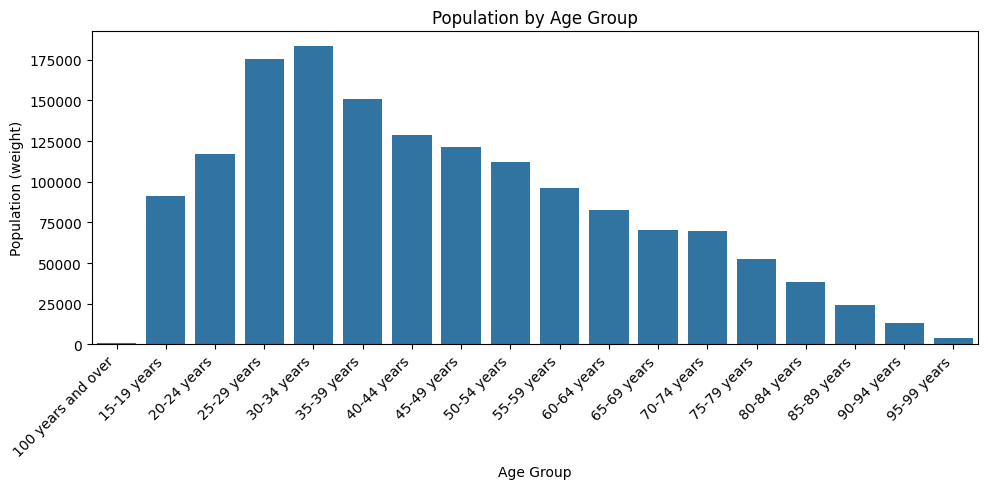

In [279]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(
    data=adult_poststrat_frame, 
    x="AGE5P Age in Five Year Groups", 
    y="weight", 
    estimator=sum, 
    errorbar=None,
    order=sorted(adult_poststrat_frame["AGE5P Age in Five Year Groups"].unique())
)
plt.title("Population by Age Group")
plt.ylabel("Population (weight)")
plt.xlabel("Age Group")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

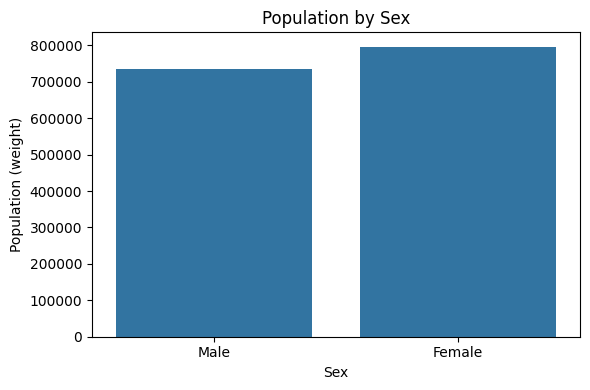

In [280]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=adult_poststrat_frame, 
    x="SEXP Sex", 
    y="weight", 
    estimator=sum, 
    errorbar=None
)
plt.title("Population by Sex")
plt.ylabel("Population (weight)")
plt.xlabel("Sex")
plt.tight_layout()
plt.show()

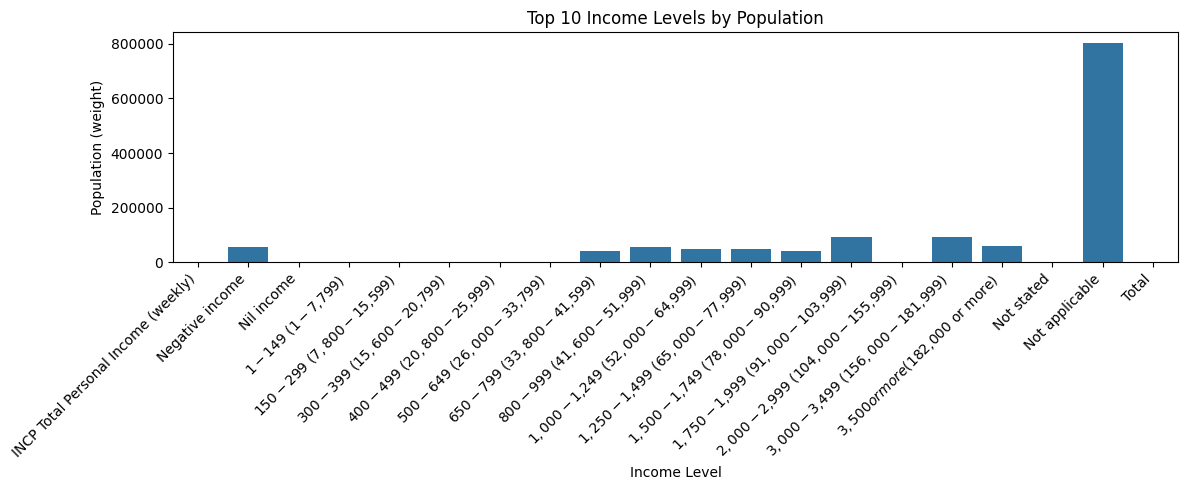

In [281]:
top_income = (
    adult_poststrat_frame.groupby("Income Level")["weight"].sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

plt.figure(figsize=(12, 5))
sns.barplot(
    data=top_income, 
    x="Income Level", 
    y="weight",
    order=income_cols
)
plt.title("Top 10 Income Levels by Population")
plt.ylabel("Population (weight)")
plt.xlabel("Income Level")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

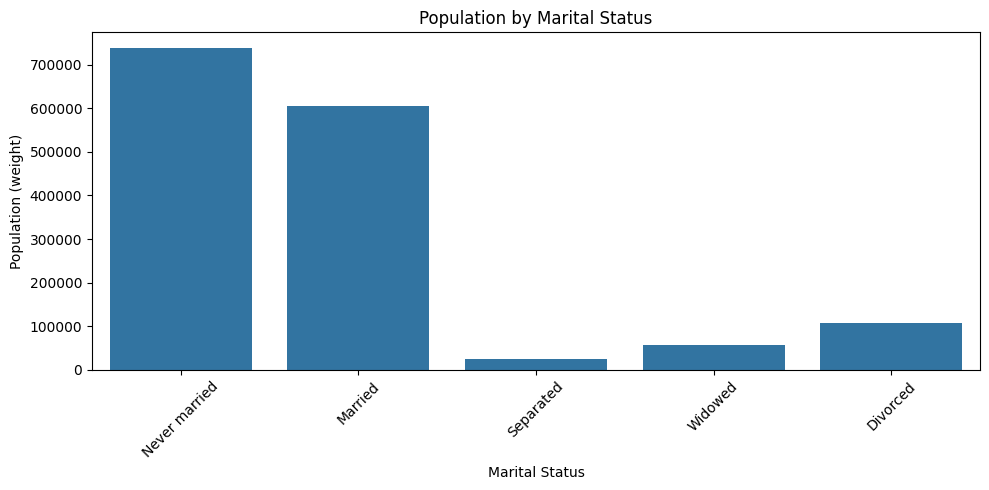

In [283]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=adult_poststrat_frame, 
    x="MSTP Registered Marital Status", 
    y="weight", 
    estimator=sum, 
    errorbar=None
)
plt.title("Population by Marital Status")
plt.ylabel("Population (weight)")
plt.xlabel("Marital Status")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

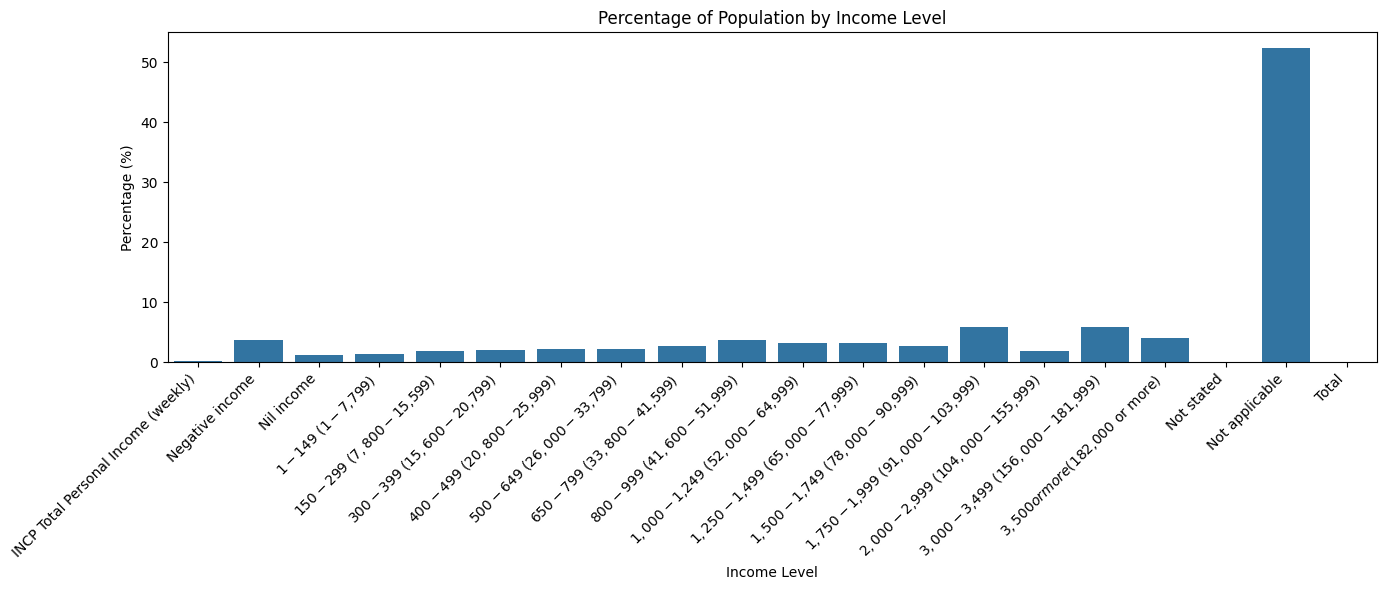

In [284]:
# Calculate total weight
total_weight = adult_poststrat_frame['weight'].sum()

# Calculate percentage for each income level
income_percent = (
    adult_poststrat_frame.groupby("Income Level")["weight"].sum()
    .reindex(income_cols)
    .fillna(0)
) / total_weight * 100

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(
    x=income_percent.index,
    y=income_percent.values,
    order=income_cols
)
plt.title("Percentage of Population by Income Level")
plt.ylabel("Percentage (%)")
plt.xlabel("Income Level")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [285]:
# Calculate the original ABS distribution by income level
abs_income_dist = (
    filtered_abs_data[income_cols].sum()
    .reindex(income_cols)
    .fillna(0)
)
abs_income_percent = (abs_income_dist / abs_income_dist.sum()) * 100

In [286]:
poststrat_income_dist = (
    adult_poststrat_frame.groupby("Income Level")["weight"].sum()
    .reindex(income_cols)
    .fillna(0)
)
poststrat_income_percent = (poststrat_income_dist / poststrat_income_dist.sum()) * 100

In [287]:
comparison_df = pd.DataFrame({
    "ABS (%)": abs_income_percent,
    "Post-stratified (%)": poststrat_income_percent
})

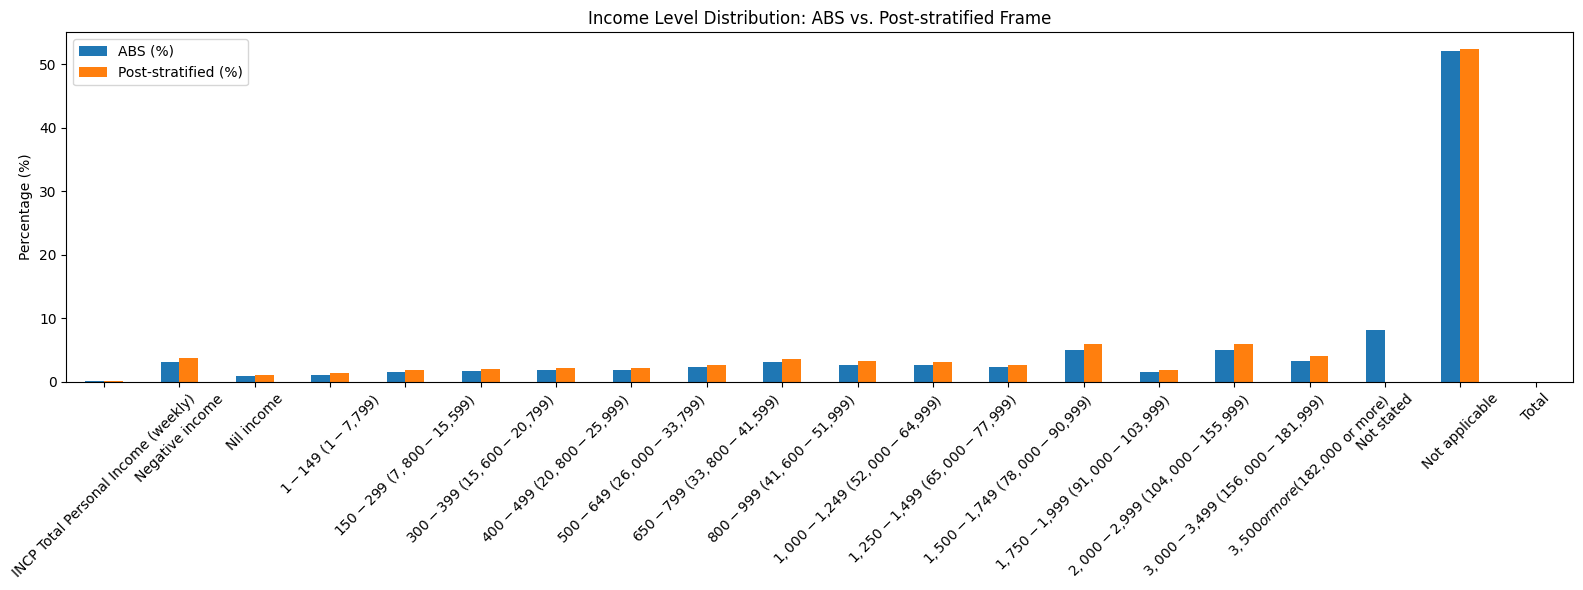

In [290]:
comparison_df.plot(
    kind='bar',
    figsize=(16, 6),
    rot=45,
    ylabel="Percentage (%)",
    title="Income Level Distribution: ABS vs. Post-stratified Frame"
)
plt.tight_layout()
plt.show()


# Compare Distributions

In [291]:
def compare_distributions(
    original_df, 
    poststrat_df, 
    category_col, 
    weight_cols=None, 
    poststrat_weight_col='weight', 
    order=None, 
    title=None, 
    figsize=(14,6)
):
    """
    Compare the distribution of a categorical variable between the original ABS data and the post-stratified frame.
    """
    # Original ABS distribution
    if weight_cols is not None:
        # For 'Income Level', melt and group
        abs_dist = (
            original_df.melt(
                id_vars=[category_col] if category_col in original_df.columns else [],
                value_vars=weight_cols,
                var_name=category_col,
                value_name='weight'
            )
            .groupby(category_col)['weight'].sum()
        )
    else:
        # For other variables, sum across all income columns for each group
        abs_dist = (
            original_df.groupby(category_col)[income_cols].sum().sum(axis=1)
        )
    
    abs_percent = (abs_dist / abs_dist.sum()) * 100

    # Post-stratified distribution
    poststrat_dist = poststrat_df.groupby(category_col)[poststrat_weight_col].sum()
    poststrat_percent = (poststrat_dist / poststrat_dist.sum()) * 100

    # Combine for comparison
    comparison = pd.DataFrame({
        "ABS (%)": abs_percent,
        "Post-stratified (%)": poststrat_percent
    }).fillna(0)

    if order is not None:
        comparison = comparison.reindex(order)

    # Plot
    comparison.plot(
        kind='bar',
        figsize=figsize,
        rot=45,
        ylabel="Percentage (%)",
        title=title or f"{category_col} Distribution: ABS vs. Post-stratified"
    )
    plt.tight_layout()
    plt.show()

## Income

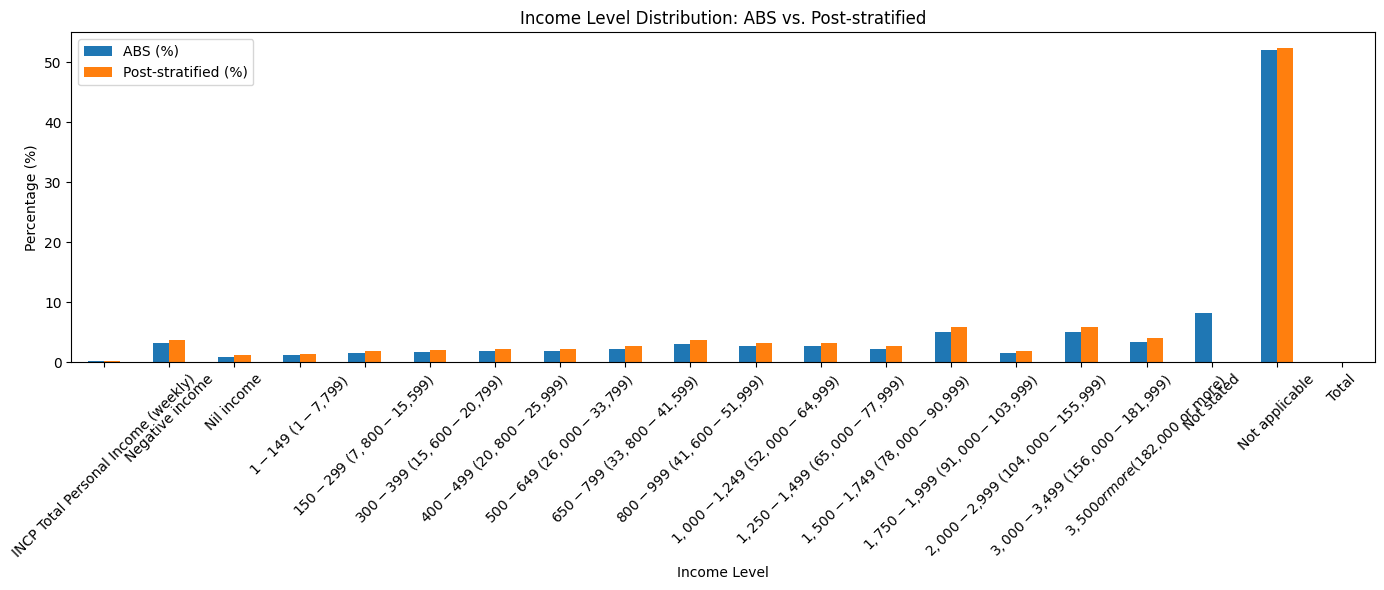

In [292]:
compare_distributions(
    original_df=filtered_abs_data,
    poststrat_df=adult_poststrat_frame,
    category_col="Income Level",
    weight_cols=income_cols,
    order=income_cols,
    title="Income Level Distribution: ABS vs. Post-stratified"
)

## Age

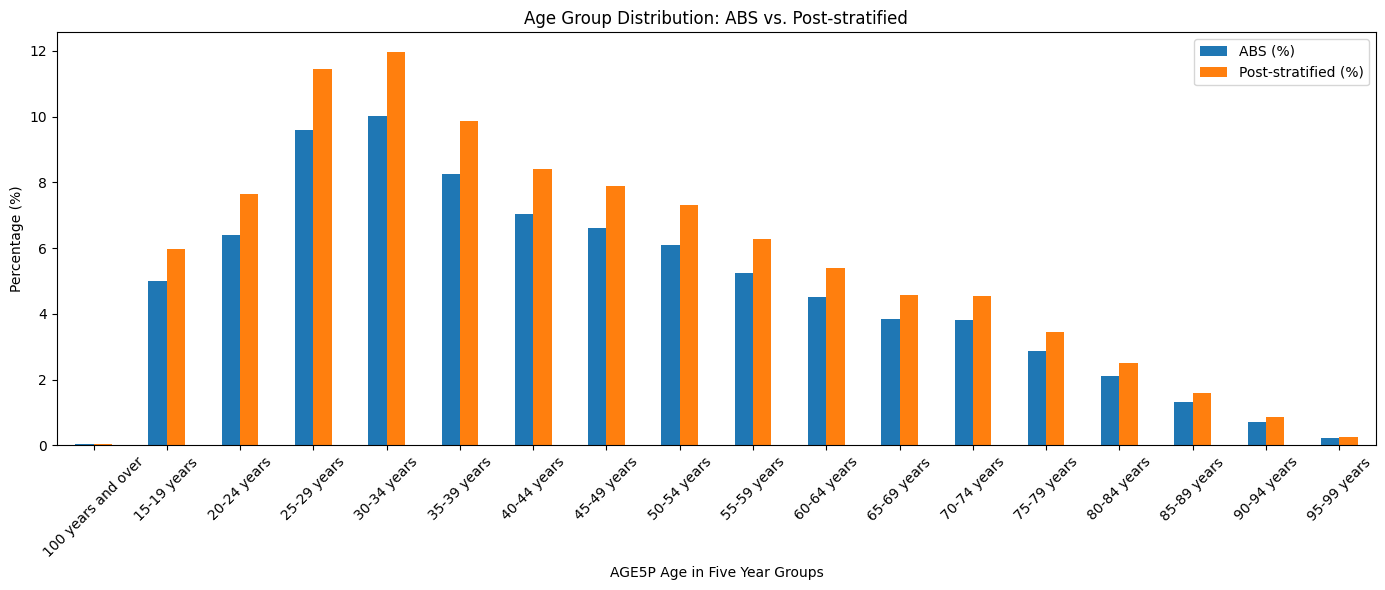

In [293]:
compare_distributions(
    original_df=filtered_abs_data,
    poststrat_df=adult_poststrat_frame,
    category_col="AGE5P Age in Five Year Groups",
    poststrat_weight_col='weight',
    order=sorted(adult_poststrat_frame["AGE5P Age in Five Year Groups"].unique()),
    title="Age Group Distribution: ABS vs. Post-stratified"
)

## Sex

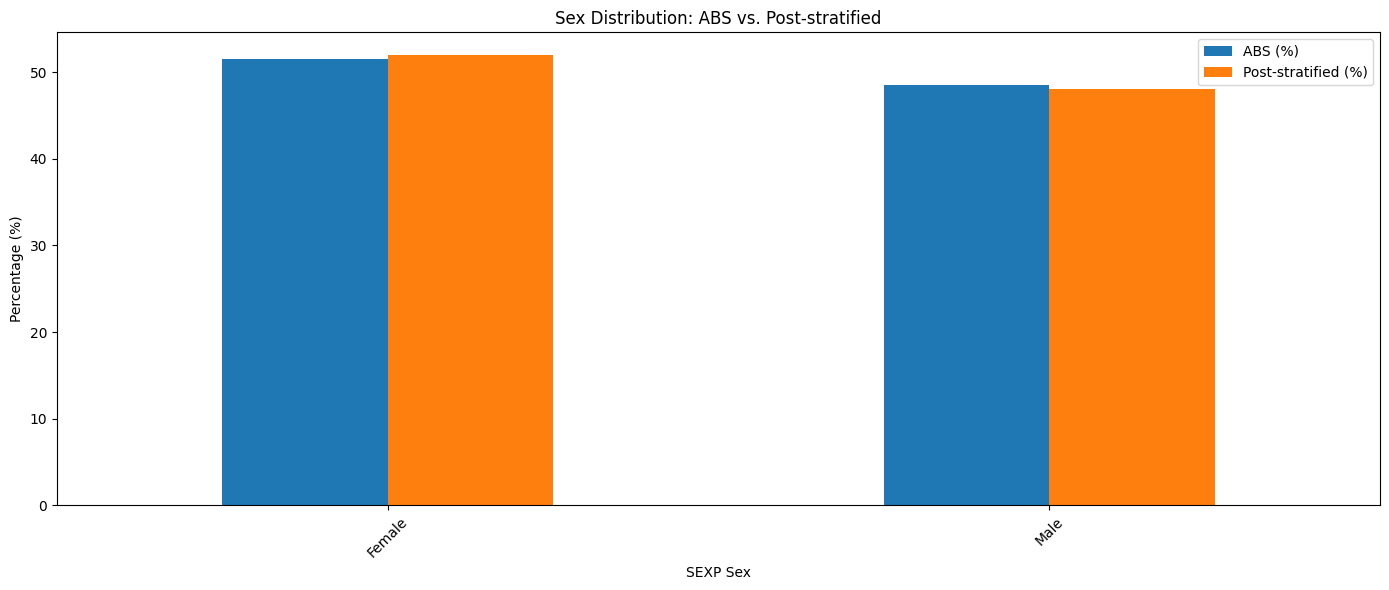

In [294]:
compare_distributions(
    original_df=filtered_abs_data,
    poststrat_df=adult_poststrat_frame,
    category_col="SEXP Sex",
    poststrat_weight_col='weight',
    order=sorted(adult_poststrat_frame["SEXP Sex"].unique()),
    title="Sex Distribution: ABS vs. Post-stratified"
)

## Marital

In [295]:
compare_distributions(
    original_df=filtered_abs_data,
    poststrat_df=adult_poststrat_frame,
    category_col="",
    weight_cols=marital_cols,
    order=marital_cols,
    title="Marital Distribution: ABS vs. Post-stratified"
)

NameError: name 'marital_cols' is not defined

In [296]:
aes_data

,ID,ID_2019,ID_2016,Mode,IntDate,Panel_retention,STATE,PCODE_r,sampsrc,accesstype,...,devicedets,H2_AGE_GRP1,H2_AGE_GRP2,G3_EDU,GCCSA,LGA_r,SA2_r,CED_ABS,weight_final,weight
0,27906849,219811230.0,5421748.0,2,2022-06-19,3,5,9,1,1.0,...,12.0,3,4,1,9,9,9,509,2577.096389,0.395509
1,27906846,219811224.0,5376708.0,2,2022-05-26,3,5,9,1,32.0,...,1.0,4,5,2,10,9,9,511,5894.088737,0.904570
2,27906845,219811221.0,5335140.0,2,2022-05-29,3,5,9,1,1.0,...,12.0,3,4,1,9,9,9,515,6780.892610,1.040669
3,27906844,219811220.0,5334955.0,2,2022-05-31,3,5,9,1,1.0,...,6.0,4,6,2,10,9,9,507,2661.392099,0.408446
4,27906843,219811219.0,5333728.0,1,2022-08-12,3,5,9,1,NaN,...,NaN,4,6,2,10,9,9,506,3485.335961,0.534897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,WF3W9T,NaN,NaN,2,2022-09-14,4,5,9,3,96.0,...,12.0,1,1,2,9,9,9,514,9509.088218,1.459367
2504,X8EM78,NaN,NaN,2,2022-09-14,4,1,9,3,96.0,...,6.0,1,1,2,1,9,9,144,11023.201854,1.691739
2505,XR9WB7,NaN,NaN,2,2022-09-15,4,2,9,3,96.0,...,12.0,1,1,1,3,9,9,218,35679.081526,5.475697
2506,YA4JE8,NaN,NaN,2,2022-09-14,4,1,9,3,96.0,...,6.0,1,1,2,1,9,9,128,14602.779095,2.241100


# Check Mappings between data sources

## Age

In [297]:
print("ABS Age groups:", poststrat_frame["AGE5P Age in Five Year Groups"].unique())
print("AES Age groups:", aes_data["AGE"].unique())  # Replace with actual AES column name

ABS Age groups: ['25-29 years' '35-39 years' '50-54 years' '15-19 years' '30-34 years'
 '70-74 years' '40-44 years' '60-64 years' '20-24 years' '80-84 years'
 '45-49 years' '55-59 years' '90-94 years' '65-69 years' '75-79 years'
 '85-89 years' '95-99 years' '100 years and over' '0-4 years' '5-9 years'
 '10-14 years']
AES Age groups: [ 52  58  48  67  70  86  65  66  69  61  76  73  40  82  63  59  27  80
  41  78  71  30  74  46  55  47  60  50  37  68  84  53  79  77  51  35
  49  94  44  26  42  72  28  62  57  43  64  90  54  75  85 999  81  83
  91  56  38  89  45  39  29  31  36  32  34  87  24  93  33  88  23  25
  21  22  20  19  92  96  95  18 107]


In [298]:
abs_to_aes_age = {
    "0-4 years" : (0, 4),
    "5-9 years" : (5, 9),
    "10-14 years" : (10, 14),
    "15-19 years" : (15, 19),
    "20-24 years": (20, 24),
    "25-29 years": (25, 29),
    "30-34 years": (30, 34),
    "35-39 years": (35, 39),
    "40-44 years": (40, 44),
    "45-49 years": (45, 49),
    "50-54 years": (50, 54),
    "55-59 years": (55, 59),
    "60-64 years": (60, 64),
    "65-69 years": (65, 69),
    "70-74 years": (70, 74),
    "75-79 years": (75, 79),
    "80-84 years": (80, 84),
    "85-89 years": (85, 89),
    "90-95 years": (90, 95),
    "96-99 years": (96, 99),
    "100 years and over": (100, 120) 
}

In [302]:
age_order = {
    "0-4 years",
    "5-9 years",
    "10-14 years",
    "15-19 years",
    "20-24 years",
    "25-29 years",
    "30-34 years",
    "35-39 years",
    "40-44 years",
    "45-49 years",
    "50-54 years",
    "55-59 years",
    "60-64 years",
    "65-69 years",
    "70-74 years",
    "75-79 years",
    "80-84 years",
    "85-89 years",
    "90-95 years",
    "96-99 years",
    "100 years and over" 
}

## Sex

In [303]:
poststrat_frame["SEXP Sex"].unique()

array(['Male', 'Female'], dtype=object)

In [304]:
aes_data['H1'].unique()  ## 1 Male, 2 Female, 3 Other

array([  1,   2,   3, 999])

In [305]:
abs_to_aes_sex = {
    "Male" : 1,
    "Female" : 2,
    
}

## Marital Status

In [306]:
poststrat_frame["MSTP Registered Marital Status"].unique()

array(['Never married', 'Married', 'Separated', 'Widowed', 'Divorced',
       'Not applicable'], dtype=object)

In [115]:
aes_data["H8"].unique()  # 1 Never Married, 2 Married, 3 Widowed, 4, Divorced or Separated

array([  4,   2,   3,   1, 999])

In [130]:
abs_to_aes_marital = {
    "Never married" : 1,
    "Married" : 2,
    "Separated" : 4,
    "Widowed" : 3,
    "Divorced" : 4
}

## Income Group

In [102]:
poststrat_frame["Income Level"].unique()

array(['INCP Total Personal Income (weekly)', 'Negative income',
       'Nil income', '$1-$149 ($1-$7,799)', '$150-$299 ($7,800-$15,599)',
       '$300-$399 ($15,600-$20,799)', '$400-$499 ($20,800-$25,999)',
       '$500-$649 ($26,000-$33,799)', '$650-$799 ($33,800-$41,599)',
       '$800-$999 ($41,600-$51,999)', '$1,000-$1,249 ($52,000-$64,999)',
       '$1,250-$1,499 ($65,000-$77,999)',
       '$1,500-$1,749 ($78,000-$90,999)',
       '$1,750-$1,999 ($91,000-$103,999)',
       '$2,000-$2,999 ($104,000-$155,999)',
       '$3,000-$3,499 ($156,000-$181,999)',
       '$3,500 or more ($182,000 or more)', 'Not stated',
       'Not applicable'], dtype=object)

In [103]:
aes_data["J6"].unique()

array([ 15,  24,  21,  25,   7, 999,  11,   5,   9,  13,  19,   1,  17,
         3])

In [116]:
# 1	Less than $15,000 per year <> 'Negative income', 'Nil income', '$1-$149 ($1-$7,799)', '$150-$299 ($7,800-$15,599)'
# 3	$15,001 to $25,000 per year <> '$300-$399 ($15,600-$20,799)', '$400-$499 ($20,800-$25,999)',
# 5	$25,001 to $35,000 per year <> '$500-$649 ($26,000-$33,799)'
# 7	$35,001 to $45,000 per year <> '$650-$799 ($33,800-$41,599)'
# 9	$45,001 to $60,000 per year <> '$800-$999 ($41,600-$51,999)', '$1,000-$1,249 ($52,000-$64,999)',
# 11	$60,001 to $80,000 per year <> '$1,250-$1,499 ($65,000-$77,999)'
# 13	$80,001 to $100,000 per year <> '$1,500-$1,749 ($78,000-$90,999)','$1,750-$1,999 ($91,000-$103,999)',
# 15	$100,001 to $120,000 per year <> '$2,000-$2,999 ($104,000-$155,999)',
# 17	$120,001 to $140,000 per year <> '$2,000-$2,999 ($104,000-$155,999)',
# 19	$140,001 to $160,000 per year <> '$3,000-$3,499 ($156,000-$181,999)',
# 21	$160,001 to $200,000 per year <> '$3,500 or more ($182,000 or more)'
# 24	$200,001 to $250,000 per year <> '$3,500 or more ($182,000 or more)'
# 25	More than $250,000 per year <> '$3,500 or more ($182,000 or more)'
# 999	Item skipped <> 'Not stated', 'Not applicable'

In [131]:
abs_to_aes_income = {
    'Negative income' : 1,
    'Nil income' : 1, 
    '$1-$149 ($1-$7,799)' : 1, 
    '$150-$299 ($7,800-$15,599)' : 1,
    '$300-$399 ($15,600-$20,799)' : 3,
    '$400-$499 ($20,800-$25,999)' : 3,
    '$500-$649 ($26,000-$33,799)' : 5,
    '$650-$799 ($33,800-$41,599)' : 7,
    '$800-$999 ($41,600-$51,999)' : 9,
    '$1,000-$1,249 ($52,000-$64,999)' : 9,
    '$1,250-$1,499 ($65,000-$77,999)' : 11,
    '$1,500-$1,749 ($78,000-$90,999)' : 13,
    '$1,750-$1,999 ($91,000-$103,999)' : 13,
    '$2,000-$2,999 ($104,000-$155,999)' : (15, 17),
    '$3,000-$3,499 ($156,000-$181,999)' : 19,
    '$3,500 or more ($182,000 or more)' : (21, 25),
    'Not stated' : 999,
    'Not applicable' : 999
}

# Mapping

## Age

In [307]:
def map_age_to_abs_age(age, abs_to_aes_age):
    for abs_cat, (min_age, max_age) in abs_to_aes_age.items():
        if pd.notnull(age) and min_age <= age <= max_age:
            return abs_cat
    return None

aes_data['ABS_AGE_CATEGORY'] = aes_data['AGE'].apply(lambda x: map_age_to_abs_age(x, abs_to_aes_age))

## Sex

In [308]:
# Invert the mapping: {1: "Male", 2: "Female"}
aes_code_to_abs_sex = {v: k for k, v in abs_to_aes_sex.items()}

# Now map the AES column to ABS labels
aes_data['ABS_SEX'] = aes_data['H1'].map(aes_code_to_abs_sex)

## Marital

In [309]:
# Invert the mapping for code → label
aes_data['ABS_MARITAL'] = aes_data['H8'].map({v: k for k, v in abs_to_aes_marital.items()})

## Income

In [310]:
def map_income_to_abs_income(aes_income, abs_to_aes_income):
    for abs_cat, aes_val in abs_to_aes_income.items():
        if isinstance(aes_val, tuple):
            if pd.notnull(aes_income) and aes_val[0] <= aes_income <= aes_val[1]:
                return abs_cat
        elif aes_income == aes_val:
            return abs_cat
    return None

aes_data['ABS_INCOME'] = aes_data['J6'].apply(lambda x: map_income_to_abs_income(x, abs_to_aes_income))

In [311]:
aes_data.head()

,ID,ID_2019,ID_2016,Mode,IntDate,Panel_retention,STATE,PCODE_r,sampsrc,accesstype,...,GCCSA,LGA_r,SA2_r,CED_ABS,weight_final,weight,ABS_AGE_CATEGORY,ABS_SEX,ABS_MARITAL,ABS_INCOME
0,27906849,219811230.0,5421748.0,2,2022-06-19,3,5,9,1,1.0,...,9,9,9,509,2577.096389,0.395509,50-54 years,Male,Divorced,"$2,000-$2,999 ($104,000-$155,999)"
1,27906846,219811224.0,5376708.0,2,2022-05-26,3,5,9,1,32.0,...,10,9,9,511,5894.088737,0.904570,55-59 years,Male,Married,"$3,500 or more ($182,000 or more)"
2,27906845,219811221.0,5335140.0,2,2022-05-29,3,5,9,1,1.0,...,9,9,9,515,6780.892610,1.040669,45-49 years,Male,Married,"$3,500 or more ($182,000 or more)"
3,27906844,219811220.0,5334955.0,2,2022-05-31,3,5,9,1,1.0,...,10,9,9,507,2661.392099,0.408446,65-69 years,Female,Married,"$3,500 or more ($182,000 or more)"
4,27906843,219811219.0,5333728.0,1,2022-08-12,3,5,9,1,NaN,...,10,9,9,506,3485.335961,0.534897,70-74 years,Male,Married,"$3,500 or more ($182,000 or more)"


# Harmonize 

In [312]:
aes_data_harmonized = aes_data.dropna(subset=['ABS_AGE_CATEGORY', 'ABS_SEX', 'ABS_MARITAL', 'ABS_INCOME'])

In [313]:
aes_data_harmonized

,ID,ID_2019,ID_2016,Mode,IntDate,Panel_retention,STATE,PCODE_r,sampsrc,accesstype,...,GCCSA,LGA_r,SA2_r,CED_ABS,weight_final,weight,ABS_AGE_CATEGORY,ABS_SEX,ABS_MARITAL,ABS_INCOME
0,27906849,219811230.0,5421748.0,2,2022-06-19,3,5,9,1,1.0,...,9,9,9,509,2577.096389,0.395509,50-54 years,Male,Divorced,"$2,000-$2,999 ($104,000-$155,999)"
1,27906846,219811224.0,5376708.0,2,2022-05-26,3,5,9,1,32.0,...,10,9,9,511,5894.088737,0.904570,55-59 years,Male,Married,"$3,500 or more ($182,000 or more)"
2,27906845,219811221.0,5335140.0,2,2022-05-29,3,5,9,1,1.0,...,9,9,9,515,6780.892610,1.040669,45-49 years,Male,Married,"$3,500 or more ($182,000 or more)"
3,27906844,219811220.0,5334955.0,2,2022-05-31,3,5,9,1,1.0,...,10,9,9,507,2661.392099,0.408446,65-69 years,Female,Married,"$3,500 or more ($182,000 or more)"
4,27906843,219811219.0,5333728.0,1,2022-08-12,3,5,9,1,NaN,...,10,9,9,506,3485.335961,0.534897,70-74 years,Male,Married,"$3,500 or more ($182,000 or more)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,WF3W9T,NaN,NaN,2,2022-09-14,4,5,9,3,96.0,...,9,9,9,514,9509.088218,1.459367,20-24 years,Male,Never married,"$300-$399 ($15,600-$20,799)"
2504,X8EM78,NaN,NaN,2,2022-09-14,4,1,9,3,96.0,...,1,9,9,144,11023.201854,1.691739,15-19 years,Female,Never married,"$1,250-$1,499 ($65,000-$77,999)"
2505,XR9WB7,NaN,NaN,2,2022-09-15,4,2,9,3,96.0,...,3,9,9,218,35679.081526,5.475697,15-19 years,Female,Never married,"$2,000-$2,999 ($104,000-$155,999)"
2506,YA4JE8,NaN,NaN,2,2022-09-14,4,1,9,3,96.0,...,1,9,9,128,14602.779095,2.241100,20-24 years,Male,Never married,"$1,250-$1,499 ($65,000-$77,999)"


# Merge

In [314]:
poststrat_for_merge = poststrat_frame.rename(columns={
    "AGE5P Age in Five Year Groups": "ABS_AGE_CATEGORY",
    "SEXP Sex": "ABS_SEX",
    "MSTP Registered Marital Status": "ABS_MARITAL",
    "Income Level": "ABS_INCOME"
    # Add more if you harmonized other variables
})

In [315]:
merged = pd.merge(
    poststrat_for_merge,
    aes_data,
    on=["ABS_AGE_CATEGORY", "ABS_SEX", "ABS_MARITAL", "ABS_INCOME"],
    how="inner"  # or "left" if you want to keep all post-strat rows
)

In [316]:
merged.head()

,SA2 (UR),ABS_AGE_CATEGORY,ABS_SEX,FPIP Parent Indicator,ABS_MARITAL,1-digit level ANCP Ancestry Multi Response,ABS_INCOME,weight_x,ID,ID_2019,...,devicedets,H2_AGE_GRP1,H2_AGE_GRP2,G3_EDU,GCCSA,LGA_r,SA2_r,CED_ABS,weight_final,weight_y
0,Bondi - Tamarama - Bronte,15-19 years,Female,Not applicable,Never married,Oceanian,Negative income,90.0,9BE4RJ,NaN,...,12.0,1,1,2,9,9,9,510,25801.738970,3.959813
1,Bondi - Tamarama - Bronte,15-19 years,Female,Not applicable,Never married,Oceanian,Negative income,90.0,9CJ89H,NaN,...,8.0,1,1,2,3,9,9,205,9786.798667,1.501988
2,Bondi - Tamarama - Bronte,15-19 years,Female,Not applicable,Never married,North-West European,Negative income,99.0,9BE4RJ,NaN,...,12.0,1,1,2,9,9,9,510,25801.738970,3.959813
3,Bondi - Tamarama - Bronte,15-19 years,Female,Not applicable,Never married,North-West European,Negative income,99.0,9CJ89H,NaN,...,8.0,1,1,2,3,9,9,205,9786.798667,1.501988
4,Bondi - Tamarama - Bronte,15-19 years,Female,Not applicable,Never married,Southern and Eastern European,Negative income,18.0,9BE4RJ,NaN,...,12.0,1,1,2,9,9,9,510,25801.738970,3.959813


In [317]:
print(f"Merged frame shape: {merged.shape}")
display(merged.head())

Merged frame shape: (139027, 372)


,SA2 (UR),ABS_AGE_CATEGORY,ABS_SEX,FPIP Parent Indicator,ABS_MARITAL,1-digit level ANCP Ancestry Multi Response,ABS_INCOME,weight_x,ID,ID_2019,...,devicedets,H2_AGE_GRP1,H2_AGE_GRP2,G3_EDU,GCCSA,LGA_r,SA2_r,CED_ABS,weight_final,weight_y
0,Bondi - Tamarama - Bronte,15-19 years,Female,Not applicable,Never married,Oceanian,Negative income,90.0,9BE4RJ,NaN,...,12.0,1,1,2,9,9,9,510,25801.738970,3.959813
1,Bondi - Tamarama - Bronte,15-19 years,Female,Not applicable,Never married,Oceanian,Negative income,90.0,9CJ89H,NaN,...,8.0,1,1,2,3,9,9,205,9786.798667,1.501988
2,Bondi - Tamarama - Bronte,15-19 years,Female,Not applicable,Never married,North-West European,Negative income,99.0,9BE4RJ,NaN,...,12.0,1,1,2,9,9,9,510,25801.738970,3.959813
3,Bondi - Tamarama - Bronte,15-19 years,Female,Not applicable,Never married,North-West European,Negative income,99.0,9CJ89H,NaN,...,8.0,1,1,2,3,9,9,205,9786.798667,1.501988
4,Bondi - Tamarama - Bronte,15-19 years,Female,Not applicable,Never married,Southern and Eastern European,Negative income,18.0,9BE4RJ,NaN,...,12.0,1,1,2,9,9,9,510,25801.738970,3.959813


In [318]:
merged['SA2 (UR)'].unique()

array(['Bondi - Tamarama - Bronte', 'Bondi Beach - North Bondi',
       'Bondi Junction - Waverly', 'Dover Heights',
       'Paddington - Moore Park', 'Rose Bay - Vaucluse - Watsons Bay',
       'Woollahra', 'Bellevue Hill', 'Double Bay - Darling Point',
       'Kensington (NSW)', 'Kingsford', 'Maroubra - North',
       'Maroubra - South', 'Maroubra - West', 'Randwick - North',
       'Randwick - South', 'Coogee - Clovelly', 'Malabar - La Perouse',
       'Matraville - Chifley', 'South Coogee', 'Total'], dtype=object)

In [319]:
merged = merged[merged['SA2 (UR)'] != 'Total'].copy()

In [320]:
merged['SA2 (UR)'].unique()

array(['Bondi - Tamarama - Bronte', 'Bondi Beach - North Bondi',
       'Bondi Junction - Waverly', 'Dover Heights',
       'Paddington - Moore Park', 'Rose Bay - Vaucluse - Watsons Bay',
       'Woollahra', 'Bellevue Hill', 'Double Bay - Darling Point',
       'Kensington (NSW)', 'Kingsford', 'Maroubra - North',
       'Maroubra - South', 'Maroubra - West', 'Randwick - North',
       'Randwick - South', 'Coogee - Clovelly', 'Malabar - La Perouse',
       'Matraville - Chifley', 'South Coogee'], dtype=object)

In [321]:
# Optionally, drop the AES weight column if you don't need it
if 'weight_y' in merged.columns:
    merged = merged.drop(columns=['weight_y'])

# For clarity, you can also rename weight_x back to weight
merged = merged.rename(columns={'weight_x': 'weight'})

# Sampling Personas

## Simple Sampling

In [322]:
import numpy as np

N = 1000  # Number of personas to draw

# Normalize weights
probabilities = merged['weight'] / merged['weight'].sum()

# Draw indices of the merged DataFrame, proportional to ABS weights
drawn_indices = np.random.choice(
    merged.index,
    size=N,
    replace=True,
    p=probabilities
)
sampled = merged.loc[drawn_indices].reset_index(drop=True)

In [323]:
sampled

,SA2 (UR),ABS_AGE_CATEGORY,ABS_SEX,FPIP Parent Indicator,ABS_MARITAL,1-digit level ANCP Ancestry Multi Response,ABS_INCOME,weight,ID,ID_2019,...,devicetype,devicedets,H2_AGE_GRP1,H2_AGE_GRP2,G3_EDU,GCCSA,LGA_r,SA2_r,CED_ABS,weight_final
0,Matraville - Chifley,65-69 years,Female,Not applicable,Married,North African and Middle Eastern,"$800-$999 ($41,600-$51,999)",5.0,27906496,219810710.0,...,0.0,8.0,4,6,1,2,9,9,131,1408.393547
1,Bondi - Tamarama - Bronte,40-44 years,Male,Not applicable,Married,Not applicable,"$3,500 or more ($182,000 or more)",23.0,27903995,NaN,...,1.0,1.0,2,3,2,15,9,9,803,11884.545358
2,Maroubra - North,60-64 years,Male,Not applicable,Never married,Not applicable,"$1,250-$1,499 ($65,000-$77,999)",4.0,27906212,219810306.0,...,0.0,8.0,4,5,2,5,9,9,307,11103.397589
3,Coogee - Clovelly,25-29 years,Female,Not applicable,Never married,North-West European,"$300-$399 ($15,600-$20,799)",9.0,27906102,219810145.0,...,0.0,8.0,1,2,1,1,9,9,119,4272.227247
4,Randwick - North,20-24 years,Male,Not applicable,Never married,Not applicable,"$1,500-$1,749 ($78,000-$90,999)",6.0,HV6AH6,NaN,...,0.0,8.0,1,1,2,1,9,9,103,13377.476561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Bondi Junction - Waverly,40-44 years,Female,Female parent,Married,Oceanian,"$2,000-$2,999 ($104,000-$155,999)",8.0,27902460,NaN,...,1.0,6.0,2,3,2,5,9,9,302,25207.007394
996,Kensington (NSW),20-24 years,Female,Not applicable,Never married,North-East Asian,"$1,500-$1,749 ($78,000-$90,999)",5.0,BR3HX4,NaN,...,0.0,8.0,1,1,2,3,9,9,231,10909.052452
997,Woollahra,75-79 years,Male,Not applicable,Married,Not applicable,"$1,500-$1,749 ($78,000-$90,999)",7.0,27906688,219810999.0,...,0.0,12.0,4,7,1,7,9,9,403,1906.216016
998,Randwick - North,30-34 years,Female,Not applicable,Never married,Southern and Eastern European,"$800-$999 ($41,600-$51,999)",11.0,27901944,NaN,...,1.0,6.0,1,2,2,3,9,9,214,17726.129967


## Better Sampling

In [324]:
N = 1000

# First, create a DataFrame of unique strata with their weights
strata_cols = ["ABS_AGE_CATEGORY", "ABS_SEX", "ABS_MARITAL", "ABS_INCOME"]  # add more if needed
strata_weights = merged.groupby(strata_cols)['weight'].first().reset_index()

# Draw N strata according to their weights
strata_probs = strata_weights['weight'] / strata_weights['weight'].sum()
drawn_strata = strata_weights.sample(
    n=N,
    replace=True,
    weights=strata_probs
).reset_index(drop=True)

# For each drawn stratum, randomly select one AES respondent from that stratum
personas = []
for _, stratum in drawn_strata.iterrows():
    # Find all AES respondents in this stratum
    matches = merged[
        (merged['ABS_AGE_CATEGORY'] == stratum['ABS_AGE_CATEGORY']) &
        (merged['ABS_SEX'] == stratum['ABS_SEX']) &
        (merged['ABS_MARITAL'] == stratum['ABS_MARITAL']) &
        (merged['ABS_INCOME'] == stratum['ABS_INCOME'])
    ]
    # Randomly select one AES respondent
    persona = matches.sample(n=1)
    personas.append(persona)

# Concatenate all sampled personas into a DataFrame
personas_df = pd.concat(personas, ignore_index=True)

In [325]:
personas_df

,SA2 (UR),ABS_AGE_CATEGORY,ABS_SEX,FPIP Parent Indicator,ABS_MARITAL,1-digit level ANCP Ancestry Multi Response,ABS_INCOME,weight,ID,ID_2019,...,devicetype,devicedets,H2_AGE_GRP1,H2_AGE_GRP2,G3_EDU,GCCSA,LGA_r,SA2_r,CED_ABS,weight_final
0,Malabar - La Perouse,75-79 years,Male,Not applicable,Widowed,North-West European,"$500-$649 ($26,000-$33,799)",4.0,27906156,219810228.0,...,NaN,NaN,4,7,2,5,9,9,307,4448.493470
1,Maroubra - West,55-59 years,Female,Female parent,Married,Not applicable,"$300-$399 ($15,600-$20,799)",4.0,27906769,219811110.0,...,0.0,12.0,4,5,1,3,9,9,239,1716.341957
2,Bondi Junction - Waverly,20-24 years,Female,Not applicable,Never married,North-East Asian,"$500-$649 ($26,000-$33,799)",3.0,KV7L3E,NaN,...,0.0,8.0,1,1,2,9,9,9,510,8243.911917
3,Dover Heights,55-59 years,Male,Male parent,Married,North African and Middle Eastern,"$3,500 or more ($182,000 or more)",6.0,27906068,219810094.0,...,1.0,6.0,4,5,1,1,9,9,103,2095.310586
4,Malabar - La Perouse,20-24 years,Male,Not applicable,Never married,North-West European,"$1,250-$1,499 ($65,000-$77,999)",3.0,27906967,219820618.0,...,1.0,6.0,1,1,2,6,9,9,314,21190.323098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Bondi Junction - Waverly,85-89 years,Male,Not applicable,Never married,North-West European,"$500-$649 ($26,000-$33,799)",3.0,27900342,NaN,...,NaN,NaN,4,7,2,1,9,9,140,3731.771991
996,Dover Heights,45-49 years,Female,Female parent,Married,North African and Middle Eastern,"$3,000-$3,499 ($156,000-$181,999)",12.0,27906275,219810400.0,...,1.0,6.0,3,4,1,7,9,9,403,4166.599295
997,Kensington (NSW),15-19 years,Female,Not applicable,Never married,Oceanian,"$650-$799 ($33,800-$41,599)",3.0,CX9VN6,NaN,...,1.0,1.0,1,1,999,1,9,9,125,9891.898651
998,Paddington - Moore Park,75-79 years,Female,Not applicable,Never married,North-West European,"$500-$649 ($26,000-$33,799)",4.0,27906333,219810467.0,...,NaN,NaN,4,7,1,4,9,9,203,1543.587312


## Big City limits sampling

In [326]:
import pandas as pd

def sample_personas_major_city(
    merged, N,
    strata_cols=["ABS_AGE_CATEGORY", "ABS_SEX", "ABS_MARITAL", "ABS_INCOME"],
    major_city_col="J5",
    major_city_value=5
):
    """
    Sample N personas from the merged frame, ensuring each persona is from a major city (J5 == 5).
    
    Parameters:
        merged: DataFrame containing merged ABS and AES data.
        N: Number of personas to sample.
        strata_cols: List of columns defining the strata.
        major_city_col: Column in AES data indicating major city status.
        major_city_value: Value in major_city_col indicating major city (default 5).
    
    Returns:
        personas_df: DataFrame of sampled personas.
    """
    # Get unique strata and their weights
    strata_weights = merged.groupby(strata_cols)['weight'].first().reset_index()
    strata_probs = strata_weights['weight'] / strata_weights['weight'].sum()

    personas = []
    attempts = 0
    max_attempts = N * 10  # Prevent infinite loops

    while len(personas) < N and attempts < max_attempts:
        # Draw one stratum according to weights
        stratum = strata_weights.sample(
            n=1,
            weights=strata_probs
        ).iloc[0]

        # Find all AES respondents in this stratum with J5 == 5
        matches = merged
        for col in strata_cols:
            matches = matches[matches[col] == stratum[col]]
        matches = matches[matches[major_city_col] == major_city_value]

        if not matches.empty:
            persona = matches.sample(n=1)
            personas.append(persona)
        # else: redraw (do nothing, try again)
        attempts += 1

    if len(personas) < N:
        print(f"Warning: Only {len(personas)} personas could be sampled with {major_city_col} == {major_city_value} after {max_attempts} attempts.")

    if personas:
        personas_df = pd.concat(personas, ignore_index=True)
    else:
        personas_df = pd.DataFrame()  # Return empty DataFrame if none found

    return personas_df

In [327]:
N = 1000
personas_df = sample_personas_major_city(merged, N)
print(personas_df.head())

                  SA2 (UR) ABS_AGE_CATEGORY ABS_SEX FPIP Parent Indicator  \
0         Maroubra - South      70-74 years  Female        Not applicable   
1            Bellevue Hill      65-69 years  Female        Not applicable   
2  Paddington - Moore Park      15-19 years    Male        Not applicable   
3         Maroubra - North      30-34 years  Female        Not applicable   
4        Coogee - Clovelly      20-24 years    Male        Not applicable   

     ABS_MARITAL 1-digit level ANCP Ancestry Multi Response  \
0        Married                        North-West European   
1        Married                             Not applicable   
2  Never married                                 Not stated   
3  Never married              Southern and Eastern European   
4  Never married                                   Oceanian   

                          ABS_INCOME  weight        ID      ID_2019  ...  \
0        $500-$649 ($26,000-$33,799)     7.0  27906723  219811050.0  ...   
1     

# Compare the Distributions

In [329]:
def compare_persona_vs_base(
    personas_df, base_df,
    persona_col, base_col,
    weight_col='weight', order=None, title=None, figsize=(14,6)
):
    """
    Compare the distribution of a categorical variable between sampled personas and the base data.
    """
    # Personas distribution (unweighted count, or use weight if you want to weight the personas)
    persona_dist = personas_df[persona_col].value_counts(normalize=True) * 100

    # Base data distribution (weighted)
    base_dist = (
        base_df.groupby(base_col)[weight_col].sum() / base_df[weight_col].sum() * 100
    )

    # Combine for comparison
    comparison = pd.DataFrame({
        "Personas (%)": persona_dist,
        "Base Data (%)": base_dist
    }).fillna(0)

    if order is not None:
        comparison = comparison.reindex(order)

    # Plot
    comparison.plot(
        kind='bar',
        figsize=figsize,
        rot=45,
        ylabel="Percentage (%)",
        title=title or f"{persona_col} Distribution: Personas vs. Base Data"
    )
    plt.tight_layout()
    plt.show()

## Age

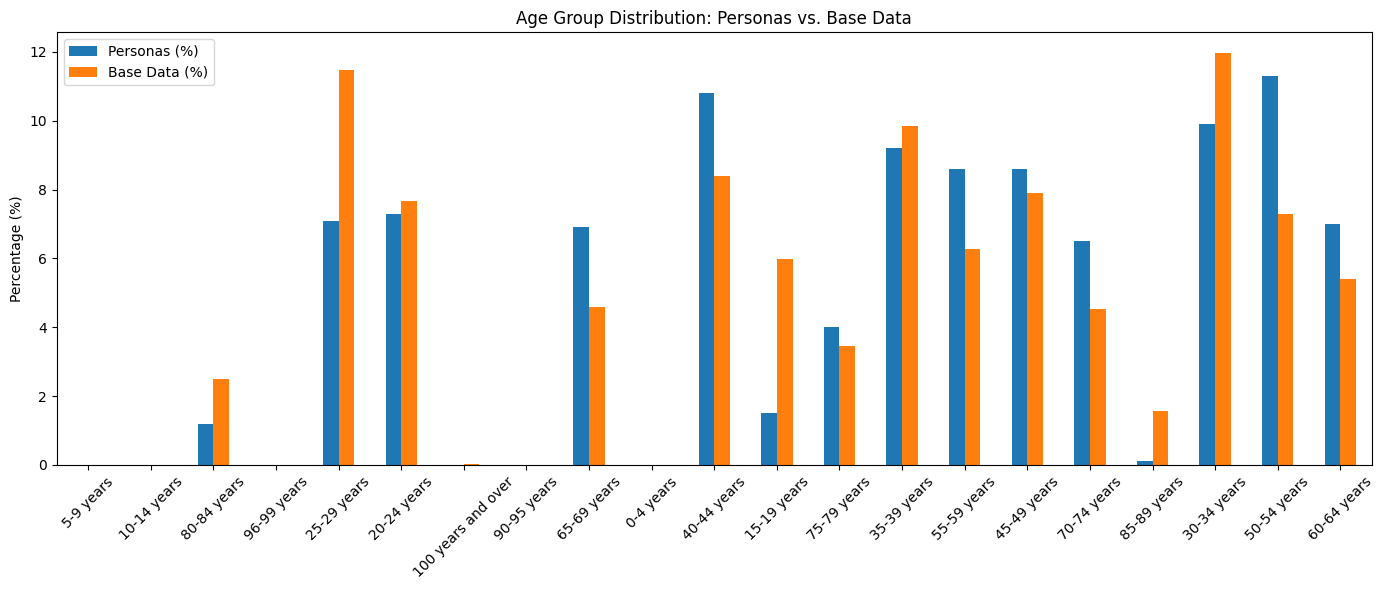

In [330]:
# List of age groups to exclude (all under 18)
exclude_ages = [
    "0-4 years", "5-9 years", "10-14 years", "15-17 years"
]

# Filter the poststrat_frame to only include adults
adult_poststrat_frame = poststrat_frame[
    ~poststrat_frame["AGE5P Age in Five Year Groups"].isin(exclude_ages)
].copy()

compare_persona_vs_base(
    personas_df=sampled,
    base_df=adult_poststrat_frame,
    persona_col="ABS_AGE_CATEGORY",
    base_col="AGE5P Age in Five Year Groups",
    order=age_order,
    title="Age Group Distribution: Personas vs. Base Data"
)

In [331]:
personas_df['ABS_AGE_CATEGORY'].unique()

array(['70-74 years', '65-69 years', '15-19 years', '30-34 years',
       '20-24 years', '25-29 years', '75-79 years', '40-44 years',
       '50-54 years', '80-84 years', '85-89 years', '55-59 years',
       '35-39 years', '45-49 years', '60-64 years'], dtype=object)

In [332]:
sorted(poststrat_frame['AGE5P Age in Five Year Groups'].unique())

['0-4 years',
 '10-14 years',
 '100 years and over',
 '15-19 years',
 '20-24 years',
 '25-29 years',
 '30-34 years',
 '35-39 years',
 '40-44 years',
 '45-49 years',
 '5-9 years',
 '50-54 years',
 '55-59 years',
 '60-64 years',
 '65-69 years',
 '70-74 years',
 '75-79 years',
 '80-84 years',
 '85-89 years',
 '90-94 years',
 '95-99 years']

## Sex

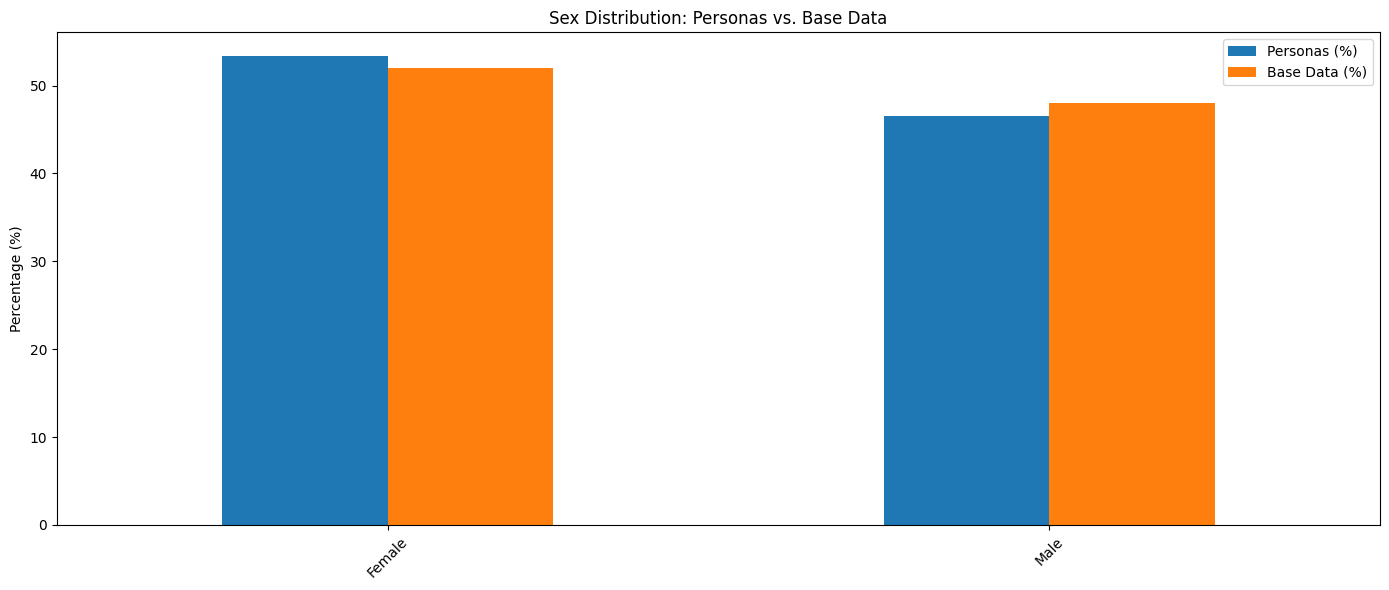

In [333]:
compare_persona_vs_base(
    personas_df=personas_df,
    base_df=adult_poststrat_frame,
    persona_col="ABS_SEX",
    base_col="SEXP Sex",
    order=sorted(poststrat_frame["SEXP Sex"].unique()),
    title="Sex Distribution: Personas vs. Base Data"
)

In [334]:
personas_df['ABS_SEX']


0      Female
1      Female
2        Male
3      Female
4        Male
        ...  
995      Male
996      Male
997      Male
998      Male
999    Female
Name: ABS_SEX, Length: 1000, dtype: object

## Marital

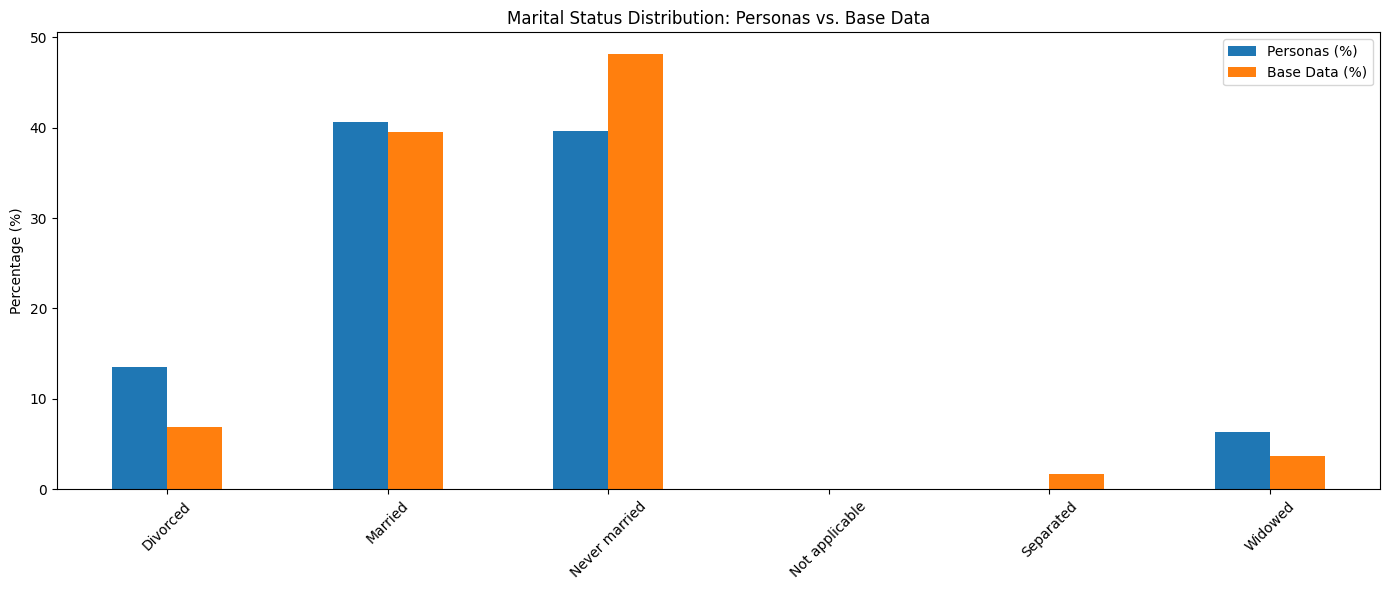

In [335]:
compare_persona_vs_base(
    personas_df=personas_df,
    base_df=adult_poststrat_frame,
    persona_col="ABS_MARITAL",           # Column in personas_df
    base_col="MSTP Registered Marital Status",  # Column in poststrat_frame
    order=sorted(poststrat_frame["MSTP Registered Marital Status"].unique()),
    title="Marital Status Distribution: Personas vs. Base Data"
)

## Income

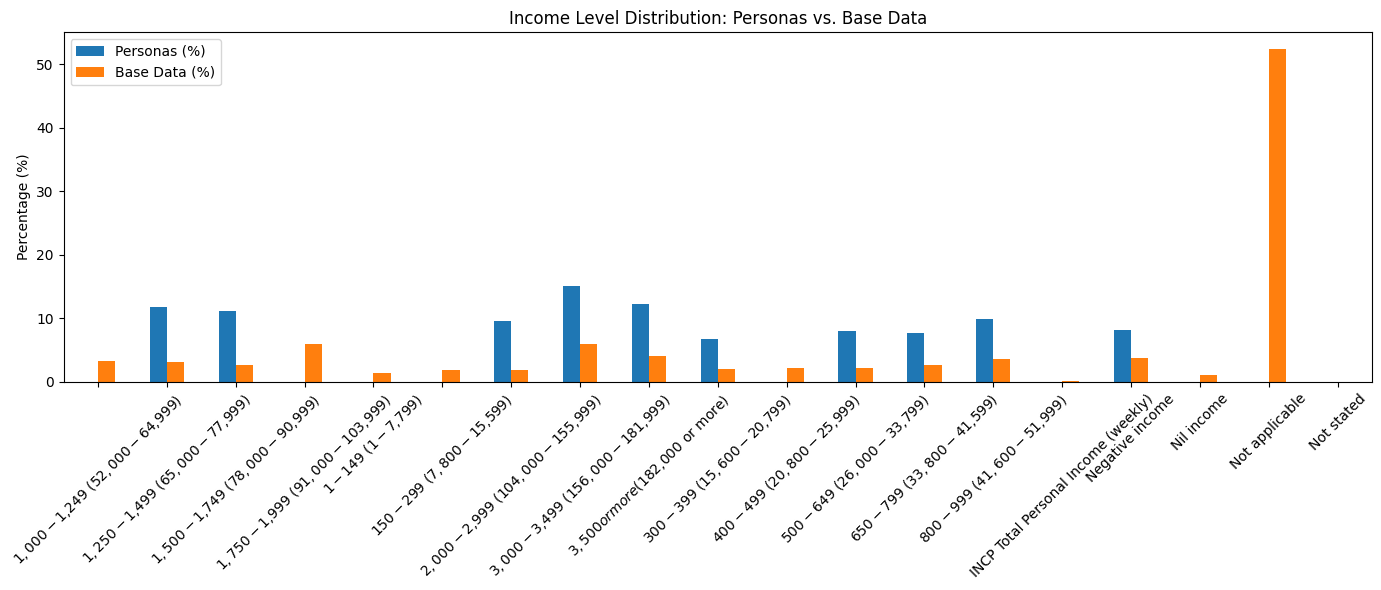

In [336]:
compare_persona_vs_base(
    personas_df=personas_df,
    base_df=adult_poststrat_frame,
    persona_col="ABS_INCOME",
    base_col="Income Level",
    order=sorted(poststrat_frame["Income Level"].unique()),
    title="Income Level Distribution: Personas vs. Base Data"
)

# Build Prompt and Pass to OpenAI

In [337]:
from pydantic import BaseModel
from typing import List, Dict, Optional

class SurveyResponse(BaseModel):
    support_level: int
    impact_on_housing: int
    impact_on_transport: int
    impact_on_community: int
    key_concerns: List[str]
    suggested_improvements: List[str]

class PersonaResponse(BaseModel):
    persona_details: Dict[str, str]
    narrative_response: str
    survey_response: SurveyResponse
    timestamp: str
    sentiment_score: Optional[float] = None
    key_themes: Optional[List[str]] = None

# If you want to use the Persona class for more detailed personas:
class Persona(BaseModel):
    name: str
    age: str
    gender: str
    location: str
    income: str
    tenure: str
    occupation: str
    education: str
    transport: str
    political_leaning: str
    trust: str
    issues: List[str]
    engagement: str

In [338]:
from textblob import TextBlob

def analyze_sentiment(text: str) -> float:
    return TextBlob(text).sentiment.polarity

In [339]:
def generate_focus_group_response(persona_row):
    # Example: create a prompt for the LLM or just a mock response
    # Here, we'll just create a mock narrative and survey response
    narrative = f"As a {persona_row['ABS_AGE_CATEGORY']} year old {persona_row['ABS_SEX']} with income {persona_row['ABS_INCOME']}, I feel strongly about this issue."
    survey = SurveyResponse(
        support_level=3,
        impact_on_housing=4,
        impact_on_transport=2,
        impact_on_community=3,
        key_concerns=["Parking", "Affordability"],
        suggested_improvements=["More public transport", "Better planning"]
    )
    sentiment_score = analyze_sentiment(narrative)
    return PersonaResponse(
        persona_details=persona_row.to_dict(),
        narrative_response=narrative,
        survey_response=survey,
        timestamp=pd.Timestamp.now().isoformat(),
        sentiment_score=sentiment_score,
        key_themes=None  # Or use your theme extraction if desired
    )

In [340]:
# J1
tenure = {
    1: "Own outright",
    2: "Own, paying off mortgage",
    3: "Rent from private landlord or real estate agent",
    4: "Rent from public housing authority",
    5: "Other (boarding, living at home, etc.)",
    999: "Item skipped"
}
# G5_D
job_type = {
    1:	'Upper managerial',
    2:	'Middle managerial',
    3:	'Lower managerial',
    4:	'Supervisory',
    5:	'Non-supervisory',
    999:	'Item skipped'
}
# G5_E
job_tenure = {
    1:	'Self-employed',
    2:  'Employee in private company or business',
    3:	'Employee of Federal / State / Local Government',
    4:	'Employee in family business or farm',
    999:	'Item skipped'
}
# G3_EDU
uni_level = {
    1:	'University',
    2:	'Non-University',
    999:	'Item skipped'
}
# G3
edu_level = {
    1: "Bachelor degree or higher",
    2: "Advanced diploma or diploma",
    3: "Certificate III/IV",
    4: "Year 12 or equivalent",
    5: "Year 11 or below",
    6: "No formal education",
    999: "Item skipped"
}
#B9_1
political_leaning = {
    1: "Liberal",
    2: "Labor",
    3: "National Party",
    4: "Greens",
    **{i: "Other party (please specify)" for i in range(5, 98)},
    999: "Item skipped"
}
# C6
trust_gov = {
    1: "Usually look after themselves",
    2: "Sometimes look after themselves",
    3: "Sometimes can be trusted to do the right thing",
    4: "Usually can be trusted to do the right thing",
    999: "Item skipped"
}

In [341]:
issues_dict = {
    "D1_1": "Taxation",
    "D1_2": "Immigration",
    "D1_3": "Education",
    "D1_4": "The environment",
    "D1_6": "Health and Medicare",
    "D1_7": "Refugees and asylum seekers",
    "D1_8": "Global warming",
    "D1_10": "Management of the economy",
    "D1_11": "The COVID-19 pandemic",
    "D1_12": "The cost of living",
    "D1_13": "National security"
}

engagement_dict = {
    "A1": "Interest in politics",
    "A2_1": "Attention to newspapers",
    "A2_2": "Attention to television",
    "A2_3": "Attention to radio",
    "A2_4": "Attention to internet",
    "A4_1": "Discussed politics in person",
    "A4_2": "Discussed politics online",
    "A4_3": "Persuaded others to vote",
    "A4_4": "Showed support for a party",
    "A4_5": "Attended political meetings",
    "A4_6": "Contributed money",
    "A7_1": "No candidate contact",
    "A7_2": "Contact by telephone",
    "A7_3": "Contact by mail",
    "A7_4": "Contact face-to-face",
    "A7_5": "Contact by SMS",
    "A7_6": "Contact by email",
    "A7_7": "Contact via social network"
}

def get_mapping_dict(variable_name):
    mapping_dict = {
        # Engagement Dictionary
        'A1': {1: 'A good deal', 2: 'Some', 3: 'Not much', 4: 'None', 999: 'Item skipped'},
        'A2_1': {1: 'A good deal', 2: 'Some', 3: 'Not much', 4: 'None at all', 999: 'Item skipped'},
        'A2_2': {1: 'A good deal', 2: 'Some', 3: 'Not much', 4: 'None at all', 999: 'Item skipped'},
        'A2_3': {1: 'A good deal', 2: 'Some', 3: 'Not much', 4: 'None at all', 999: 'Item skipped'},
        'A2_4': {1: 'A good deal', 2: 'Some', 3: 'Not much', 4: 'None at all', 999: 'Item skipped'},
        'A4_1': {1: 'Frequently', 2: 'Occasionally', 3: 'Rarely', 4: 'Not at all', 999: 'Item skipped'},
        'A4_2': {1: 'Frequently', 2: 'Occasionally', 3: 'Rarely', 4: 'Not at all', 999: 'Item skipped'},
        'A4_3': {1: 'Frequently', 2: 'Occasionally', 3: 'Rarely', 4: 'Not at all', 999: 'Item skipped'},
        'A4_4': {1: 'Frequently', 2: 'Occasionally', 3: 'Rarely', 4: 'Not at all', 999: 'Item skipped'},
        'A4_5': {1: 'Frequently', 2: 'Occasionally', 3: 'Rarely', 4: 'Not at all', 999: 'Item skipped'},
        'A4_6': {1: 'Frequently', 2: 'Occasionally', 3: 'Rarely', 4: 'Not at all', 999: 'Item skipped'},

        # Issues Dictionary
        'D1_1': {1: 'Extremely important', 2: 'Quite important', 3: 'Not very important', 999: 'Item skipped'},
        'D1_2': {1: 'Extremely important', 2: 'Quite important', 3: 'Not very important', 999: 'Item skipped'},
        'D1_3': {1: 'Extremely important', 2: 'Quite important', 3: 'Not very important', 999: 'Item skipped'},
        'D1_4': {1: 'Extremely important', 2: 'Quite important', 3: 'Not very important', 999: 'Item skipped'},
        'D1_6': {1: 'Extremely important', 2: 'Quite important', 3: 'Not very important', 999: 'Item skipped'},
        'D1_7': {1: 'Extremely important', 2: 'Quite important', 3: 'Not very important', 999: 'Item skipped'},
        'D1_8': {1: 'Extremely important', 2: 'Quite important', 3: 'Not very important', 999: 'Item skipped'},
        'D1_10': {1: 'Extremely important', 2: 'Quite important', 3: 'Not very important', 999: 'Item skipped'},
        'D1_11': {1: 'Extremely important', 2: 'Quite important', 3: 'Not very important', 999: 'Item skipped'},
        'D1_12': {1: 'Extremely important', 2: 'Quite important', 3: 'Not very important', 999: 'Item skipped'},
        'D1_13': {1: 'Extremely important', 2: 'Quite important', 3: 'Not very important', 999: 'Item skipped'},
    }
    return mapping_dict.get(variable_name, {})

print(get_mapping_dict('A1'))


{1: 'A good deal', 2: 'Some', 3: 'Not much', 4: 'None', 999: 'Item skipped'}


In [342]:
def row_to_persona(row):
    return Persona(
        name=f"Persona_{row.name}",
        age=row.get('ABS_AGE_CATEGORY', 'Unknown'),
        gender=row.get('ABS_SEX', 'Unknown'),
        location=row.get('SA2 (UR)', 'Unknown'),
        income=row.get('ABS_INCOME', 'Unknown'),
        tenure=tenure.get(row.get('J1', 999), 'Unknown'),
        job_tenure=job_tenure.get(row.get('G5_E', 999), 'Unknown'),
        occupation=job_type.get(row.get('G5_D', 999), 'Unknown'),
        education=edu_level.get(row.get('G3', 999), 'Unknown'),
        political_leaning=political_leaning.get(row.get('B9_1', 999), 'Unknown'), 
        trust = trust_gov.get(row.get('C6', 999), 'Unknown'),
        issues=[],
        engagement="Unknown"
    )
    

# LLM Prompt

In [346]:
def generate_persona_response(persona: Persona, client: OpenAI) -> PersonaResponse:
    """
    Generate a persona's response to the local proposal using OpenAI API.
    
    Args:
        persona (Persona): Persona object containing demographic information
        client (OpenAI): OpenAI client instance
        
    Returns:
        PersonaResponse: Complete response including both narrative and survey data
    """
    prompt = f"""You are simulating the response of a fictional but demographically grounded persona for use in a synthetic civic focus group. This persona is based on Australian Census data and local electoral trends.

Persona Details:
- Name: {persona.name}
- Age: {persona.age}  
- Gender: {persona.gender}  
- Location: {persona.location}, NSW  
- Income: {persona.income}  
- Tenure: {persona.tenure}  
- Job Tenure: {persona.job_tenure}
- Occupation: {persona.occupation}  
- Education: {persona.education}  
- Political Leaning: {persona.political_leaning}  
- Trust in Government: {persona.trust}  
- Key Issues: {issues_text}  
- Engagement Level: {engagement_text}

You have been asked to react to the following **local proposal**:

> "Waverley Council is considering a policy that would remove minimum parking requirements for new apartment developments in Bondi. This means developers could build fewer or no car spaces if they believe it suits the residents' needs."

IMPORTANT: Based on your demographic profile, you should take a strong position on this issue. Consider how your background might lead you to have extreme views:

- If you're a car-dependent commuter, you might strongly oppose this policy
- If you're a young renter who doesn't own a car, you might strongly support it
- If you're concerned about housing affordability, you might see this as a crucial step
- If you're worried about parking in your neighborhood, you might see this as a major threat
- If you're environmentally conscious, you might view this as essential for sustainability
- If you're a property owner, you might be concerned about impacts on property values

Please provide:

1. A short narrative response (2-3 sentences) that reflects:
   - A clear, strong position on the policy (either strongly support or strongly oppose)
   - Why — in your own words, as someone with this background
   - What specific impacts you're most concerned about

2. A structured survey response with the following:
   - Support Level (1-5, where 1 is strongly oppose and 5 is strongly support)
   - Impact on Housing Affordability (1-5, where 1 is very negative and 5 is very positive)
   - Impact on Transport (1-5, where 1 is very negative and 5 is very positive)
   - Impact on Community (1-5, where 1 is very negative and 5 is very positive)
   - Key Concerns (comma-separated list)
   - Suggested Improvements (comma-separated list)

Where possible, reflect your opinion using tone and language that matches your demographic and issue profile. Don't be afraid to take strong positions based on your background.

**Relevant local context for grounding:**
- Reddit post (r/sydney, 2023): "There are too many ghost garages in Bondi. We need more housing, not car spots."
- Grattan Institute: 68% of renters under 35 support relaxed parking minimums in high-transit areas.
- AEC data: Bondi Junction booths saw 30%+ Green vote among young renters in 2022.
- Local resident group: "Parking is already a nightmare. This will make it worse."
- Property developer: "Parking minimums add $50,000+ to each apartment's cost."

Format your response as follows:

NARRATIVE RESPONSE:
[Your narrative response here]

SURVEY RESPONSE:
Support Level: [1-5]
Impact on Housing: [1-5]
Impact on Transport: [1-5]
Impact on Community: [1-5]
Key Concerns: [comma-separated list]
Suggested Improvements: [comma-separated list]"""
    
    response = client.chat.completions.create(
        model="gpt-4-turbo-preview",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that simulates realistic persona responses based on demographic data. You should encourage strong, diverse viewpoints based on demographic factors."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7  # Add some variation to responses
    )
    
    response_text = response.choices[0].message.content
    
    # Split the response into narrative and survey parts
    parts = response_text.split('SURVEY RESPONSE:')
    narrative = parts[0].replace('NARRATIVE RESPONSE:', '').strip()
    survey = parts[1].strip() if len(parts) > 1 else ""
    
    # Parse the survey response
    survey_response = parse_survey_response(survey)
    
    # Analyze sentiment and extract themes
    sentiment_score = analyze_sentiment(narrative)
    key_themes = extract_key_themes(narrative, client)
    
    return PersonaResponse(
        persona_details={
            "name": persona.name,
            "age": persona.age,
            "location": persona.location,
            "occupation": persona.occupation,
            "political_leaning": persona.political_leaning
        },
        narrative_response=narrative,
        survey_response=survey_response,
        timestamp=datetime.now().isoformat(),
        sentiment_score=sentiment_score,
        key_themes=key_themes
    )# Initialize your OpenAI client


In [251]:
print('D1_Order \n', personas_df['D1_Order'])


D1_Order 
 0      k,d,l,b,j,f,a,c,g,h,m
1      h,g,j,f,a,m,b,d,l,c,k
2      j,c,b,g,d,m,k,a,h,f,l
3      c,h,a,b,f,l,g,j,k,m,d
4      f,a,k,h,g,l,b,j,d,c,m
               ...          
995    h,a,k,b,j,m,l,f,c,d,g
996    a,b,c,d,f,g,h,j,k,l,m
997    a,l,h,j,k,f,c,g,m,d,b
998    h,d,g,m,l,k,a,j,f,b,c
999    j,a,k,d,h,g,l,m,b,c,f
Name: D1_Order, Length: 1000, dtype: object


In [253]:
def letters_to_ordinals(letter_string):
    """
    Converts a comma-separated string of letters to their ordinal values (a=1, b=2, ..., z=26).
    Handles both single letters and multi-letter codes (e.g., 'eh').
    """
    # Create mapping for a-z
    letter_map = {chr(i + 96): i for i in range(1, 27)}
    
    # Split the input string by commas and strip whitespace
    codes = [code.strip().lower() for code in letter_string.split(',')]
    
    # Convert each code to its ordinal value(s)
    result = []
    for code in codes:
        # For multi-letter codes, convert each letter and join as a string
        ordinals = [str(letter_map.get(char, '?')) for char in code if char.isalpha()]
        result.append(','.join(ordinals))
    
    return result

# Example usage:
input_string = "k,d,l,b,j,f,a,c,g,h,m"
output = letters_to_ordinals(input_string)
print(output)  # Output: ['1', '7', '4', '18', '5,8']

['11', '4', '12', '2', '10', '6', '1', '3', '7', '8', '13']


In [345]:
def construct_engagement_string(row, personas_df):
    engagement_str = "I engage in politics in the following way: "
    parts = []
    for key, description in engagement_dict.items():
        answer_value = personas_df.at[row.name, key] if key in personas_df.columns else 999
        answer_text = get_mapping_dict(key).get(answer_value, "Unknown")
        if answer_text not in ["Item skipped", "Unknown"]:
            parts.append(f"{description}, {answer_text}")
    if parts:
        engagement_str += "; ".join(parts)
    else:
        engagement_str = "No significant engagement reported."
    return engagement_str


def construct_issues_string(row, personas_df):
    issues_str = "How I feel about the following Issues include: "
    parts = []
    for key, description in issues_dict.items():
        answer_value = personas_df.at[row.name, key] if key in personas_df.columns else 999
        answer_text = get_mapping_dict(key).get(answer_value, "Unknown")
        if answer_text not in ["Item skipped", "Unknown"]:
            parts.append(f"{description}, {answer_text}")
    if parts:
        issues_str += "; ".join(parts)
    else:
        issues_str = "No significant issues reported."
    return issues_str


engagement_text = construct_engagement_string(personas_df.iloc[0], personas_df)
issues_text = construct_issues_string(personas_df.iloc[0], personas_df)
print(engagement_text)
print(issues_text)


I engage in politics in the following way: Interest in politics, A good deal; Attention to television, None at all; Attention to internet, None at all; Discussed politics in person, Occasionally; Discussed politics online, Not at all; Persuaded others to vote, Not at all; Showed support for a party, Not at all; Attended political meetings, Not at all; Contributed money, Not at all
How I feel about the following Issues include: Taxation, Extremely important; Immigration, Quite important; Education, Extremely important; The environment, Not very important; Health and Medicare, Extremely important; Refugees and asylum seekers, Quite important; Global warming, Not very important; Management of the economy, Quite important; The COVID-19 pandemic, Extremely important; The cost of living, Extremely important; National security, Extremely important


In [349]:
from dotenv import load_dotenv

load_dotenv()

True

In [350]:
from openai import OpenAI
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))


In [ ]:

# Generate responses
persona_objects = [row_to_persona(row) for _, row in personas_df.iterrows()]
responses = [generate_persona_response(persona, client) for persona in persona_objects]